In [138]:
import os
import git
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True
from scipy.spatial import Delaunay


In [139]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
main_df = pd.read_pickle(save_path_with_hull)
main_df["orientation"] = main_df["orientation"].fillna("fourier", inplace=False)
main_df_all = main_df.copy()
main_df = main_df[main_df["failure_type"] == "pass"]
np.random.seed(0)

In [140]:
def in_hull(p, hull):
    if hasattr(hull, 'vertices') and not isinstance(hull, Delaunay):
        hull = Delaunay(hull.points)
    elif not isinstance(hull, Delaunay):
        hull = Delaunay(hull)
    return hull.find_simplex(p) >= 0

def get_hull_centroid(hull, log =False):
    # Extract ordered convex hull vertices
    polygon = hull.points[hull.vertices]
    if log:
        polygon = np.log10(polygon)

    # Close the polygon if needed
    if not np.allclose(polygon[0], polygon[-1]):
        polygon = np.vstack([polygon, polygon[0]])

    x, y = polygon[:, 0], polygon[:, 1]
    cross = x[:-1] * y[1:] - x[1:] * y[:-1]
    area = 0.5 * np.sum(cross)

    if np.isclose(area, 0):
        return np.mean(polygon, axis=0)  # fallback for degenerate polygon

    cx = np.sum((x[:-1] + x[1:]) * cross) / (6 * area)
    cy = np.sum((y[:-1] + y[1:]) * cross) / (6 * area)

    return np.array([cx, cy])
def in_hull_list(p, hulls):
   return np.any([in_hull(p, hull) for hull in hulls], axis=0)

# Remote Sensing

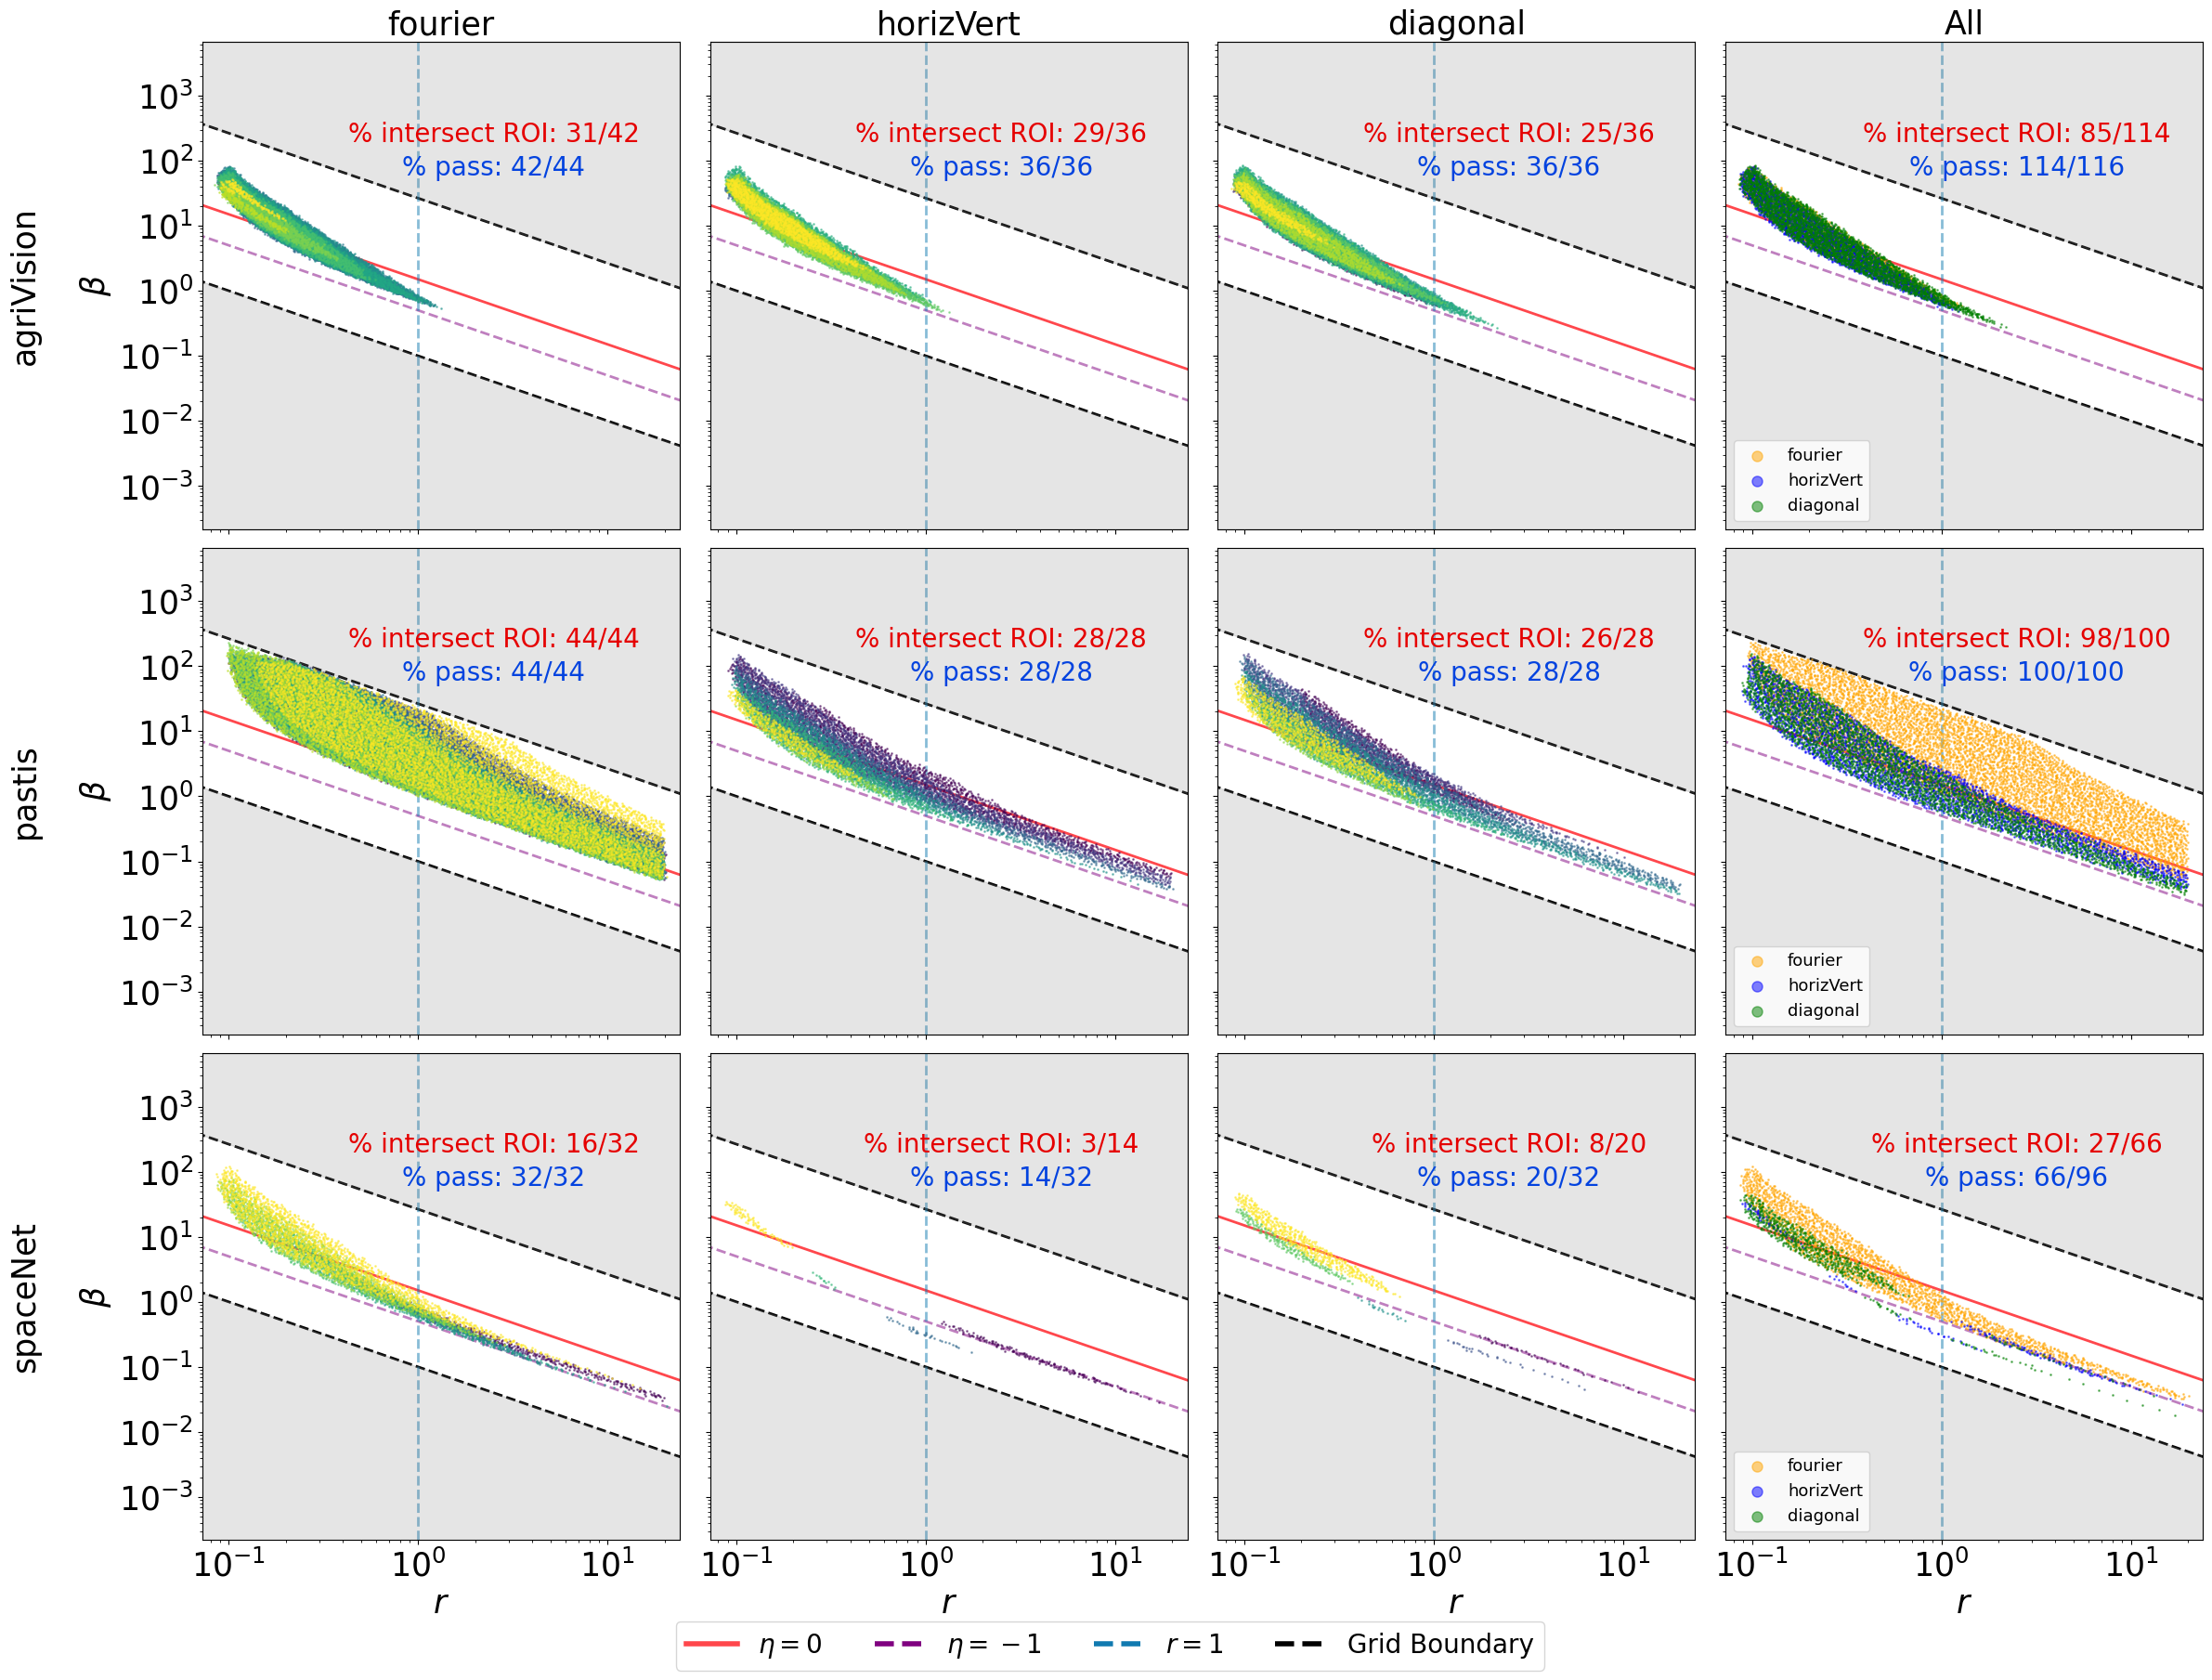

In [141]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("agriVision", "full"), ("pastis", "full"), ("spaceNet", "full")]
directions = ["fourier", "horizVert", "diagonal"]
fontsize=25

# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf
for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])
        df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned") & (main_df_all["orientation"] == direction)].copy()
        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin
            
        color_map = plt.get_cmap('viridis')
        num_groups = len(group_list)
        group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}

        x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
        y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
        
        xx, yy = np.meshgrid(x_vals, y_vals)
        points_grid = np.c_[xx.ravel(), yy.ravel()]
        for k, hull in enumerate(hull_list):
            hull_mask = in_hull_list(points_grid, hull)
            points = points_grid[hull_mask]
            points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
            ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        temp_df = df[df["orientation"] == direction]
        #ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")
        
        pass_percent = f"{len(temp_df)}/{len(df_all)}"
        intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"
        ax.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
            textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
        ax.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
            textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))

    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[i, 3]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned")].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned")].copy()
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()

    orientation_colors = {"horizVert": "blue", "diagonal": "green", "fourier": "orange", "vertical": "purple", "horizontal": "red"}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    
    temp_df = df
    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

    ax4.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
            textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    ax4.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    #ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend(markerscale=8, fontsize=fontsize-12)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)

col_labels = directions + ["All"]
for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, fontsize=fontsize)

for ax, dataset in zip(axes[:, 0], datasets):
    ax.annotate(dataset[0], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 25, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=fontsize, rotation=90)
                
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        if j == 0:
            ax.set_ylabel(r"$\beta$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_ylabel("")
        
        if i == 2:
            ax.set_xlabel(r"$r$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_xlabel("")

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$"),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$'),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize - 5, bbox_to_anchor=(0.5, -0.01), ncol=len(legend_elements))
plt.tight_layout(rect=[0, 0.02, 1, 1])
#plt.subplots_adjust(wspace=0.1, hspace=0.1)


plt.show()

    
if SAVE_FIGS:
    #fig.savefig(os.path.join(plots_path, "region_pointalism_remote_sensing.png"), bbox_inches='tight', dpi=1000)
    ""

# Natural Images

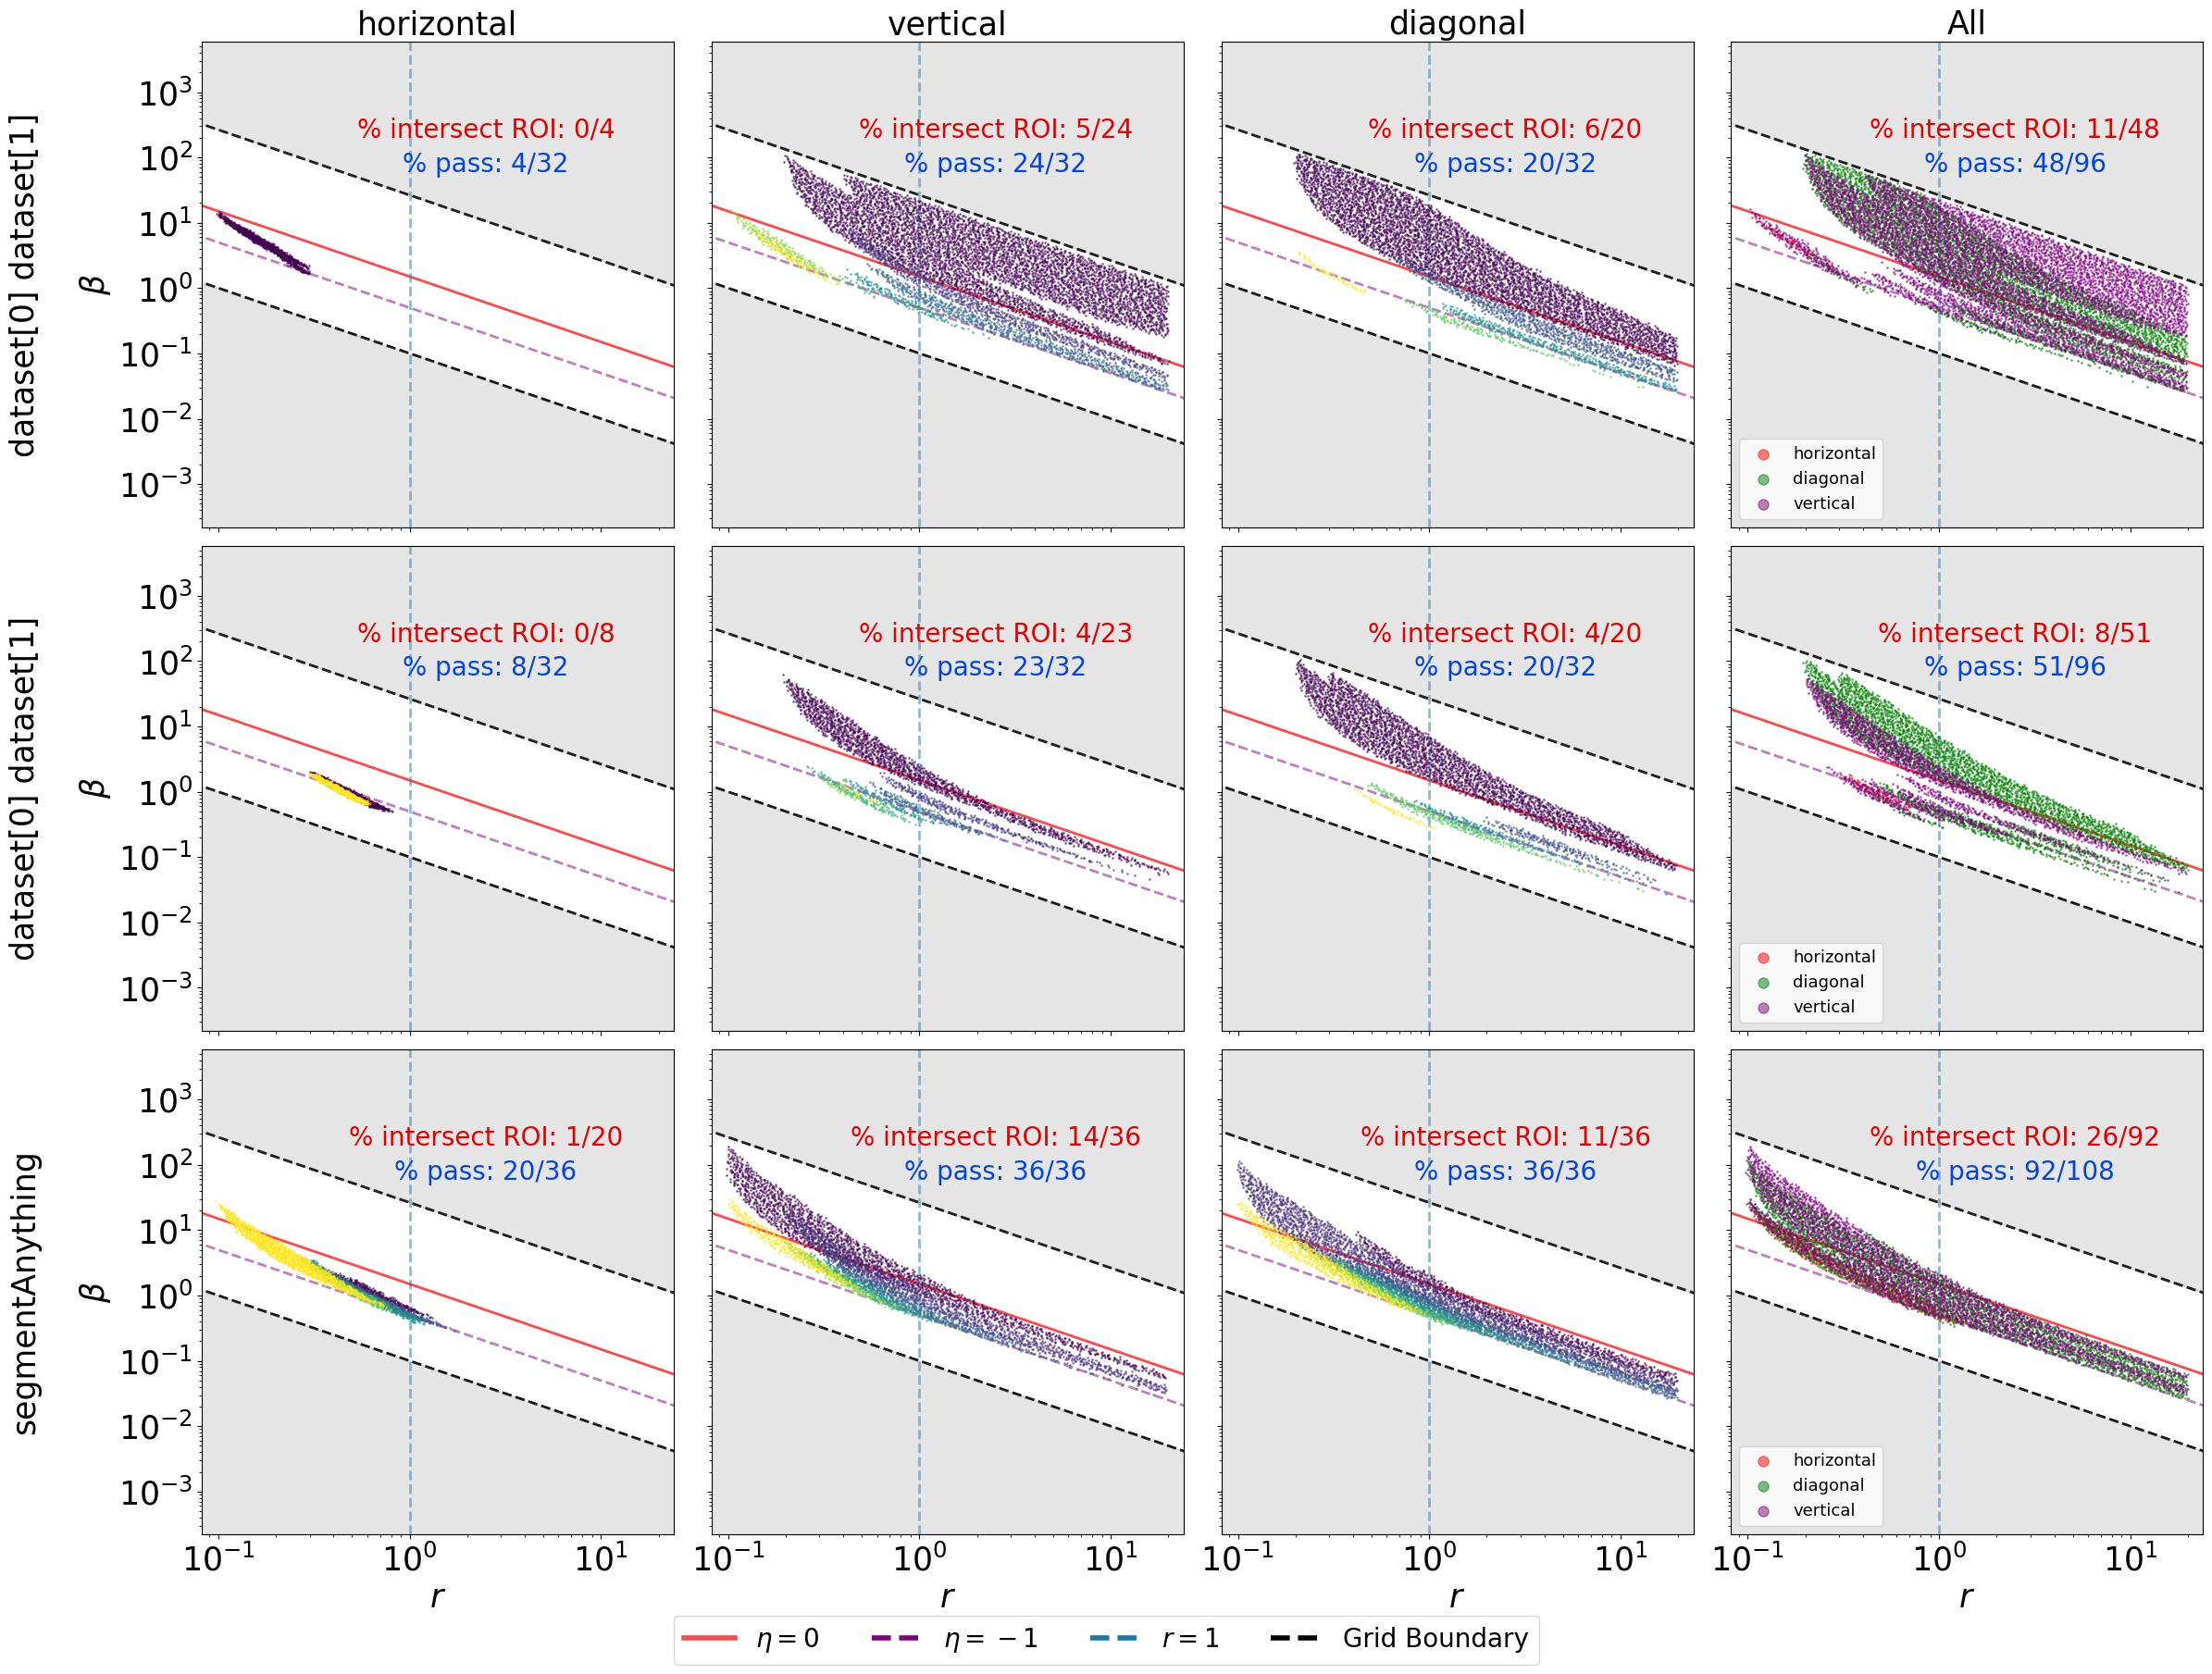

In [142]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("coco", "indoor"), ("coco", "outdoor"), ("segmentAnything", "full")]
directions = ["horizontal", "vertical", "diagonal"]
fontsize=25

# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf
for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])
        df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned") & (main_df_all["orientation"] == direction)].copy()
        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin
            
        color_map = plt.get_cmap('viridis')
        num_groups = len(group_list)
        group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}

        x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
        y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
        
        xx, yy = np.meshgrid(x_vals, y_vals)
        points_grid = np.c_[xx.ravel(), yy.ravel()]
        for k, hull in enumerate(hull_list):
            hull_mask = in_hull_list(points_grid, hull)
            points = points_grid[hull_mask]
            points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
            ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        temp_df = df[df["orientation"] == direction]
        #ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")
        
        pass_percent = f"{len(temp_df)}/{len(df_all)}"
        intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"
        ax.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
            textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
        ax.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
            textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))

    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[i, 3]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned")].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned")].copy()
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()

    orientation_colors = {"horizVert": "blue", "diagonal": "green", "fourier": "orange", "vertical": "purple", "horizontal": "red"}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    
    temp_df = df
    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

    ax4.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
            textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    ax4.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    #ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend(markerscale=8, fontsize=fontsize-12)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)

col_labels = directions + ["All"]
for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, fontsize=fontsize)

for ax, dataset in zip(axes[:, 0], datasets):
    if dataset[0] == "coco":
        ax.annotate(f"dataset[0] dataset[1]", xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 25, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=fontsize, rotation=90)
    else:
        ax.annotate(dataset[0], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 25, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=fontsize, rotation=90)
                
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        if j == 0:
            ax.set_ylabel(r"$\beta$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_ylabel("")
        
        if i == 2:
            ax.set_xlabel(r"$r$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_xlabel("")

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$"),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$'),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize - 5, bbox_to_anchor=(0.5, -0.01), ncol=len(legend_elements))
plt.tight_layout(rect=[0, 0.02, 1, 1])

plt.show()

    
if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_natural.png"), bbox_inches='tight', dpi=1000)

# Medical

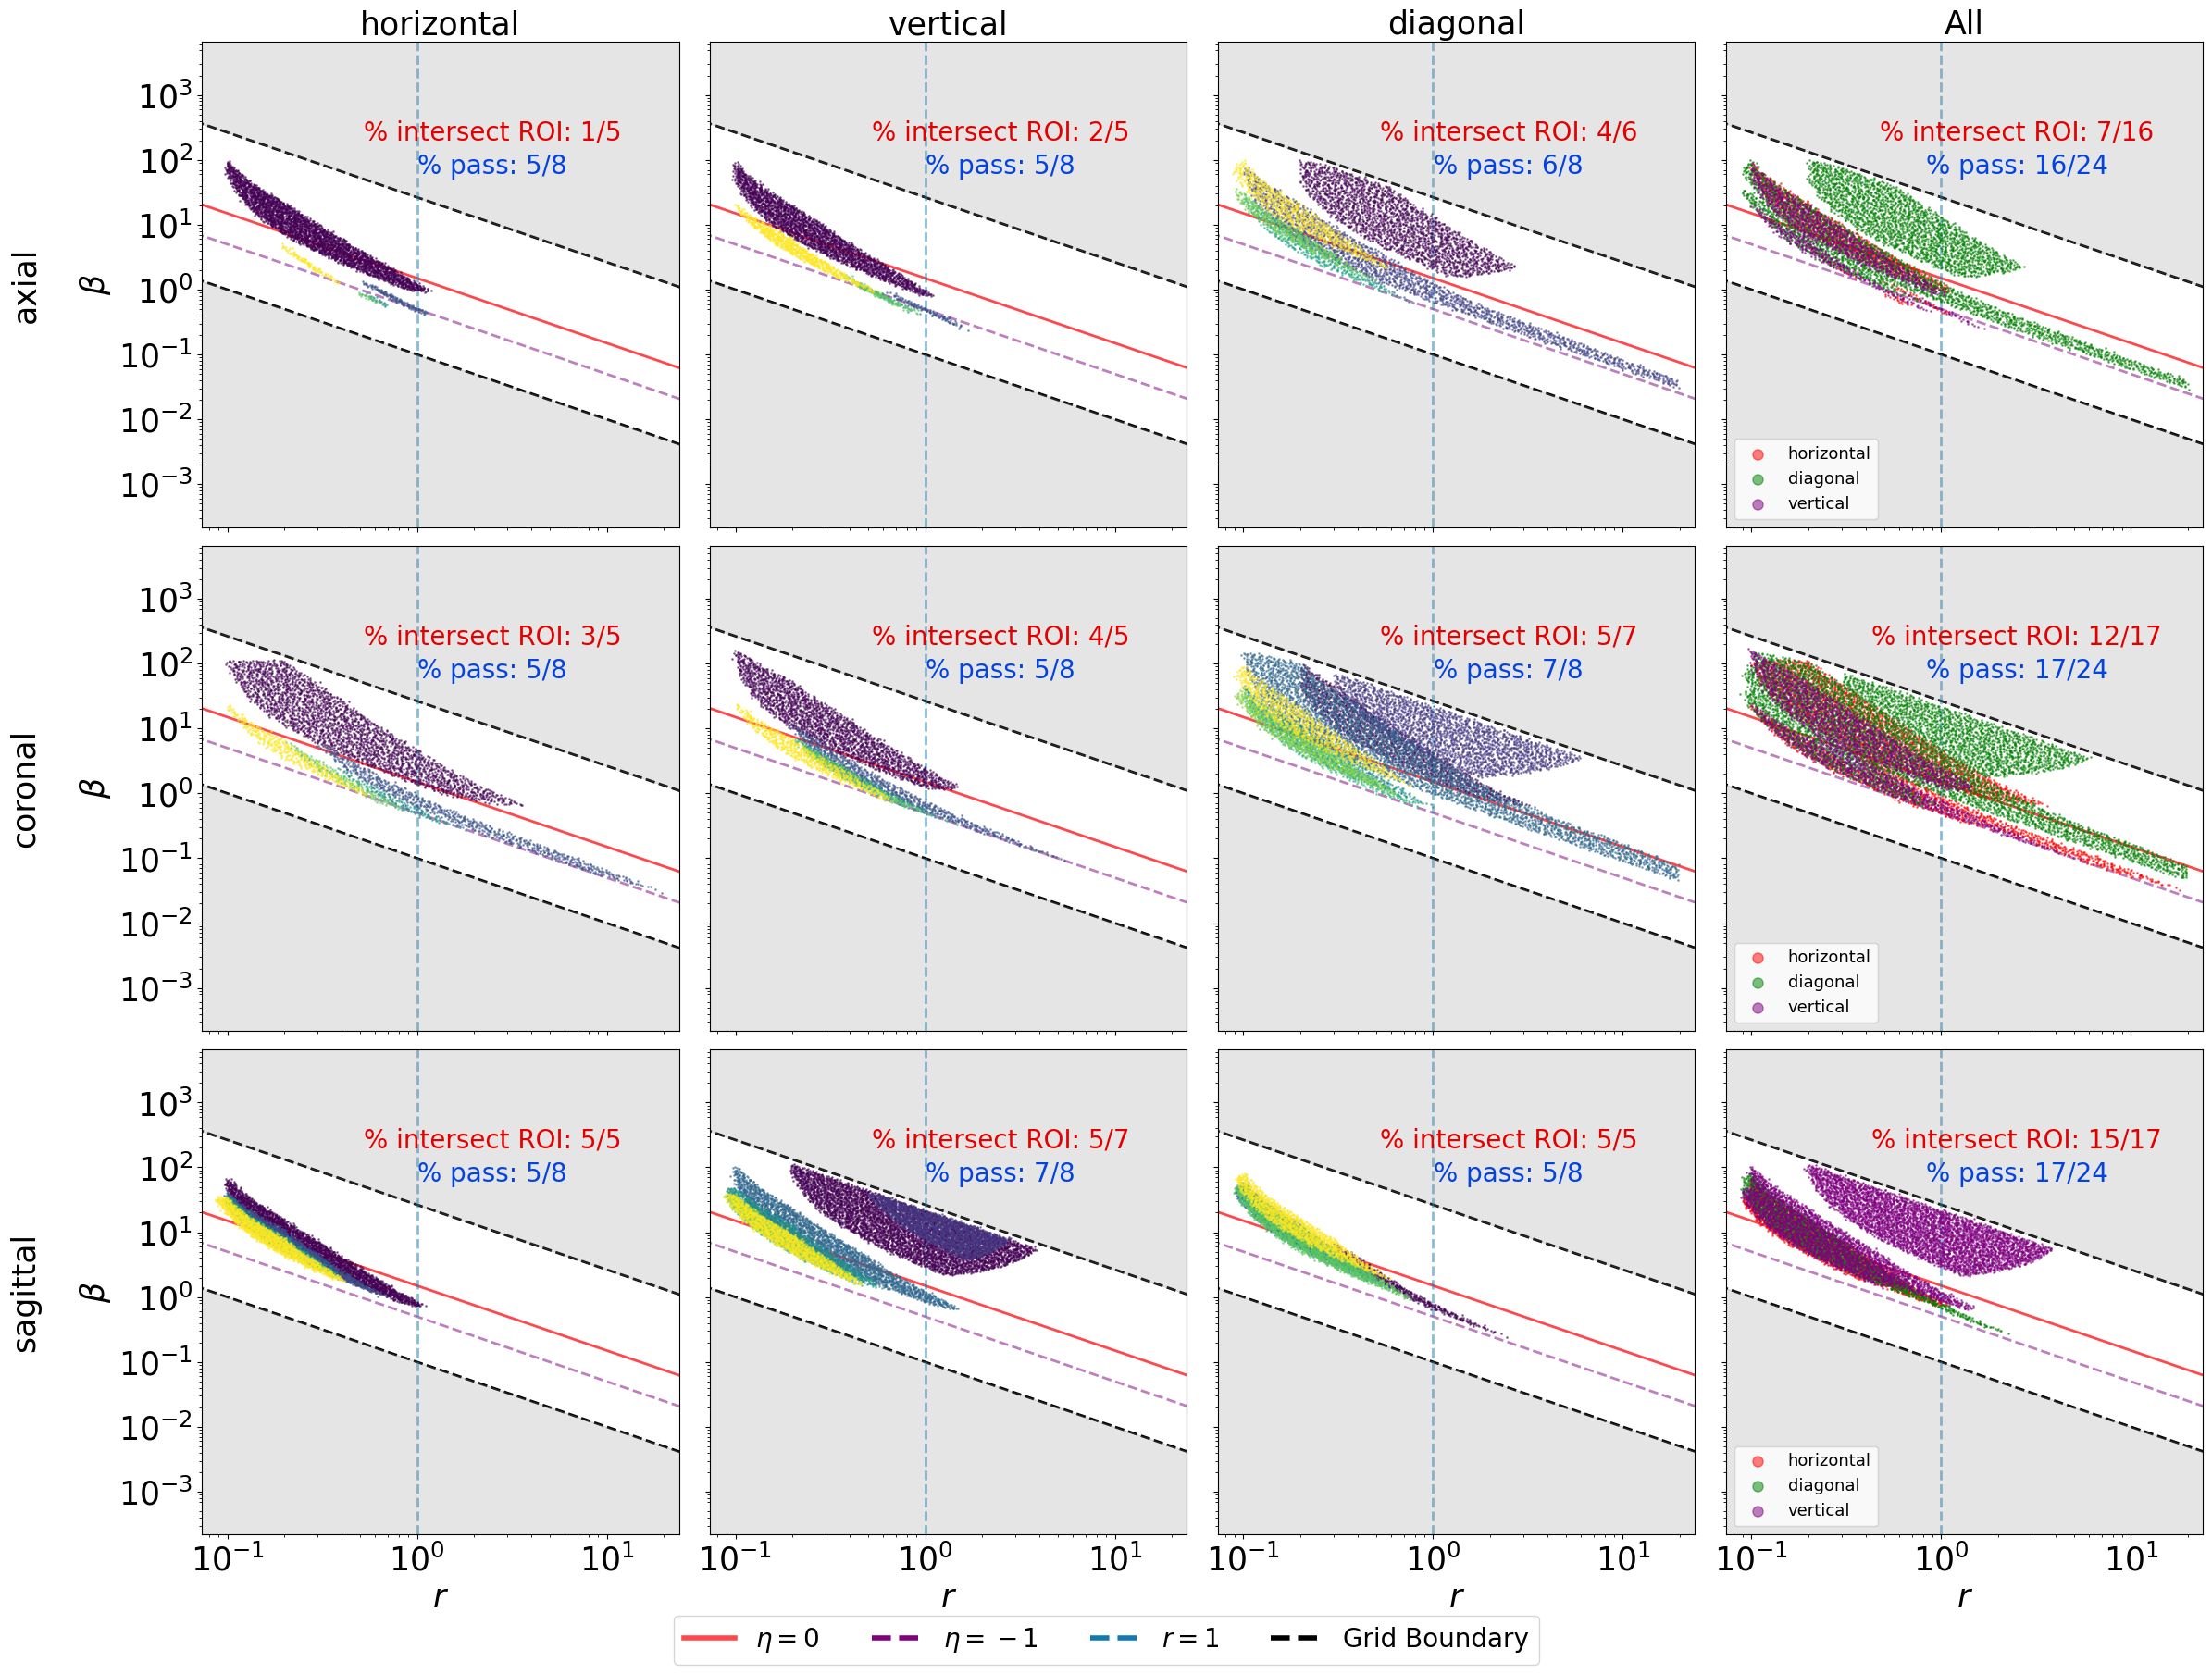

In [143]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("syntheticMRI2D", "axial"), ("syntheticMRI2D", "coronal"), ("syntheticMRI2D", "sagittal")]
directions = ["horizontal", "vertical", "diagonal"]
fontsize=25

# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf
for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        ax = axes[i, j]
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])
        df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned") & (main_df_all["orientation"] == direction)].copy()
        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin
            
        color_map = plt.get_cmap('viridis')
        num_groups = len(group_list)
        group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}

        x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
        y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
        
        xx, yy = np.meshgrid(x_vals, y_vals)
        points_grid = np.c_[xx.ravel(), yy.ravel()]
        for k, hull in enumerate(hull_list):
            hull_mask = in_hull_list(points_grid, hull)
            points = points_grid[hull_mask]
            points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
            ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        temp_df = df[df["orientation"] == direction]
        #ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")
        
        pass_percent = f"{len(temp_df)}/{len(df_all)}"
        intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"
        ax.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
            textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
        ax.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
            textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))

    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[i, 3]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned")].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned")].copy()
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()

    orientation_colors = {"horizVert": "blue", "diagonal": "green", "fourier": "orange", "vertical": "purple", "horizontal": "red"}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    
    temp_df = df
    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

    ax4.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
            textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    ax4.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    #ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend(markerscale=8, fontsize=fontsize-12)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)

col_labels = directions + ["All"]
for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, fontsize=fontsize)

for ax, dataset in zip(axes[:, 0], datasets):
    ax.annotate(dataset[1], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 25, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=fontsize, rotation=90)
                
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        if j == 0:
            ax.set_ylabel(r"$\beta$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_ylabel("")
        
        if i == 2:
            ax.set_xlabel(r"$r$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_xlabel("")

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$"),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$'),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize - 5, bbox_to_anchor=(0.5, -0.01), ncol=len(legend_elements))
plt.tight_layout(rect=[0, 0.02, 1, 1])

plt.show()
    
if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_MRI2D.png"), bbox_inches='tight', dpi=1000)

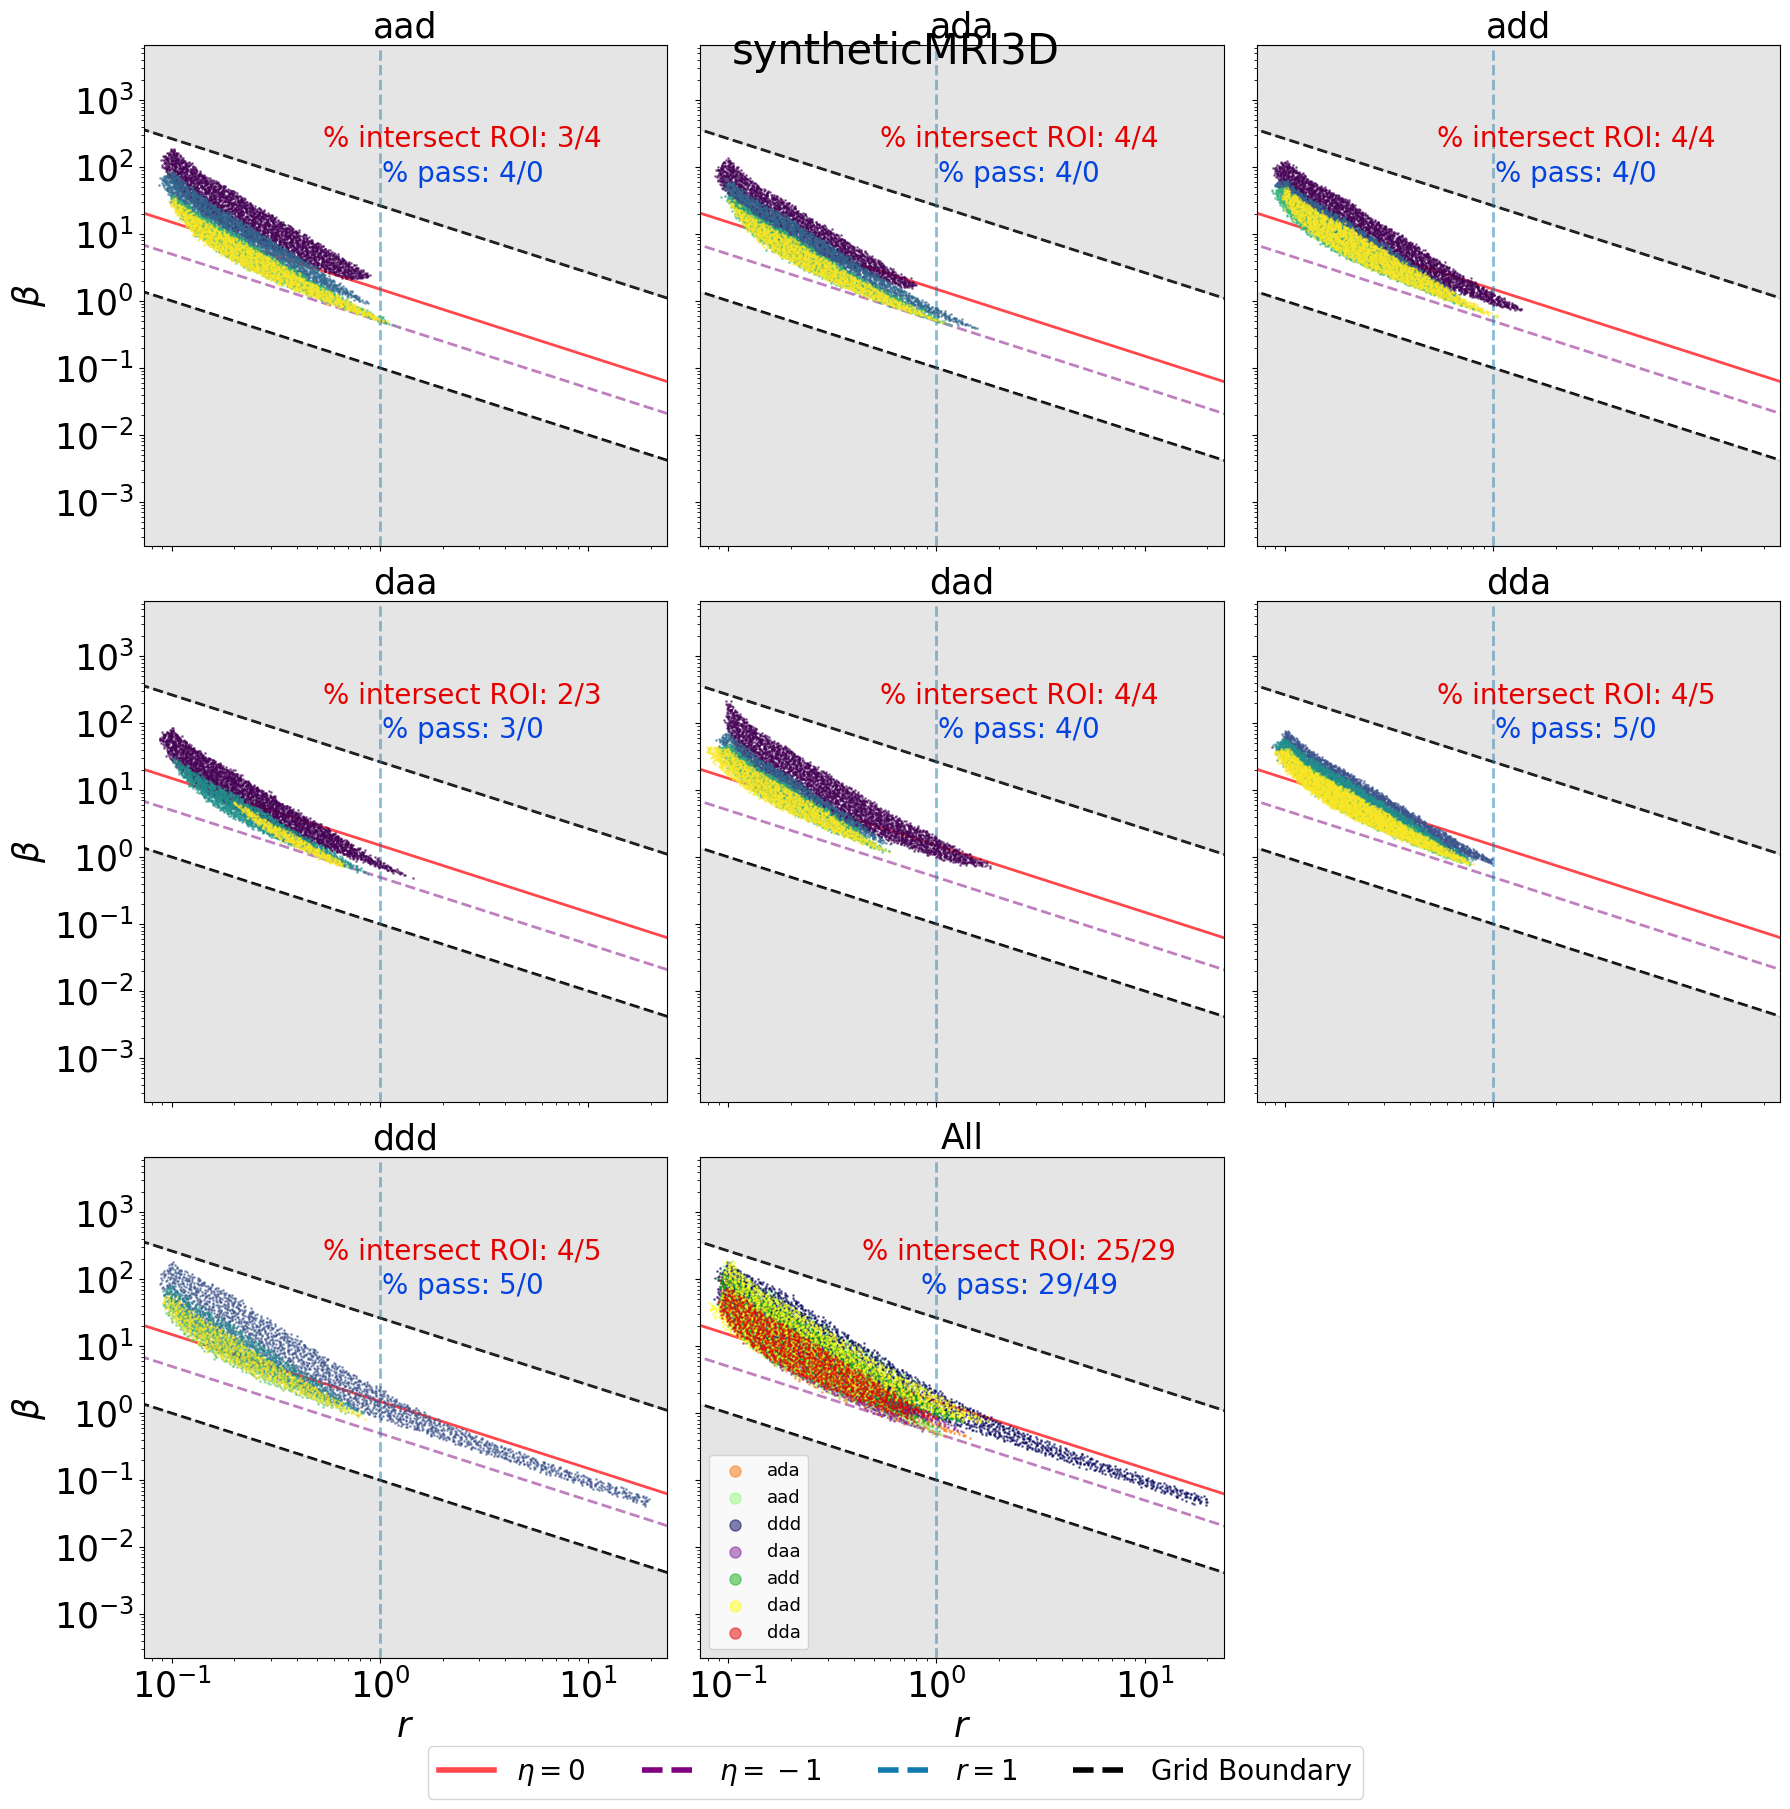

In [144]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("syntheticMRI3D", "full")]
directions = ["aad", "ada", "add", "daa", "dad", "dda", "ddd", "aaa"]

fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)
color_map = plt.get_cmap('tab10')

for idx, direction in enumerate(directions):
    i, j = divmod(idx, 3)
    ax = axes[i, j]
    df = main_df[(main_df["dataset"] == datasets[0][0]) & (main_df["subset"] == datasets[0][1]) & (main_df["transform"] != "learned") & (main_df["orientation"] == direction)].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned") & (main_df_all["orientation"] == direction)].copy()

    group_list = df["group"].unique()
    hull_list = []
    all_hulls = []
    for group in group_list:
        hull_list.append(df[df["group"] == group]["hull"])
        all_hulls.extend(df[df["group"] == group]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    color_map = plt.get_cmap('viridis')
    # Use equally spaced colors from the colormap for each group
    num_groups = len(group_list)
    group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}
    
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        # Use group_colors with correct index for each group
        ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=f"{group_list[k]}", alpha=0.5, color=color_map(k / max(len(hull_list) - 1, 1)))

    ax.set_xlabel("r")
    ax.set_ylabel("1/beta")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f"{datasets[0][0]}-{datasets[0][1]}-{direction}")
    temp_df = df[df["orientation"] == direction]

    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"
    ax.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
        textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    ax.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5))

    ax.set_title(f"{direction}", fontsize=fontsize)

# Hide the last (bottom right) subplot
axes[2, 2].axis('off')

# Fourth column: plot by orientation for each DATASET
ax4 = axes[2, 1]
df = main_df[(main_df["dataset"] == datasets[0][0]) & (main_df["subset"] == datasets[0][1]) & (main_df["transform"] != "learned")].copy()
df = df.dropna(subset=["hull"])
df_all = main_df_all[(main_df_all["dataset"] == datasets[0][0]) & (main_df_all["subset"] == datasets[0][1]) & (main_df_all["transform"] != "learned")].copy()
if df["dataset_type"].unique()[0] == "remote sensing":
    df["orientation"] = df["orientation"].fillna("fourier")
orientation_list = df["orientation"].unique()
hull_list = []
all_hulls = []
for orientation in orientation_list:
    hull_list.append(df[df["orientation"] == orientation]["hull"])
    all_hulls.extend(df[df["orientation"] == orientation]["hull"])

all_points = np.vstack([hull.points for hull in all_hulls])
xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
orientation_colors = {
    'aad': 'xkcd:light green',
    'ada': 'xkcd:orange',
    'add': 'xkcd:green',
    'daa': 'xkcd:purple',
    'dad': 'xkcd:yellow',
    'dda': 'xkcd:red',
    'ddd': 'xkcd:dark blue'
}
x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)

xx, yy = np.meshgrid(x_vals, y_vals)
points_grid = np.c_[xx.ravel(), yy.ravel()]
for k, hull in enumerate(hull_list):
    hull_mask = in_hull_list(points_grid, hull)
    points = points_grid[hull_mask]
    points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
    ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    
temp_df = df
pass_percent = f"{len(temp_df)}/{len(df_all)}"
intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

ax4.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
        textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
ax4.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
    textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
    bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
#ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
ax4.set_title(f"All", fontsize=fontsize)
ax4.legend(markerscale=8, fontsize=fontsize-12)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)
        # Hide the bottom right plot (axes[2, 2])

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        if j == 0:
            ax.set_ylabel(r"$\beta$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_ylabel("")
        
        if i == 2:
            ax.set_xlabel(r"$r$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_xlabel("")

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$"),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$'),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize - 5, bbox_to_anchor=(0.5, -0.01), ncol=len(legend_elements))
plt.tight_layout(rect=[0, 0.02, 1, 1])

axes[2, 2].set_visible(False)
plt.suptitle(f"{datasets[0][0]}", fontsize=fontsize+5)
plt.show()

    
if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_MRI3D.png"), bbox_inches='tight', dpi=1000)

# Standard Testing

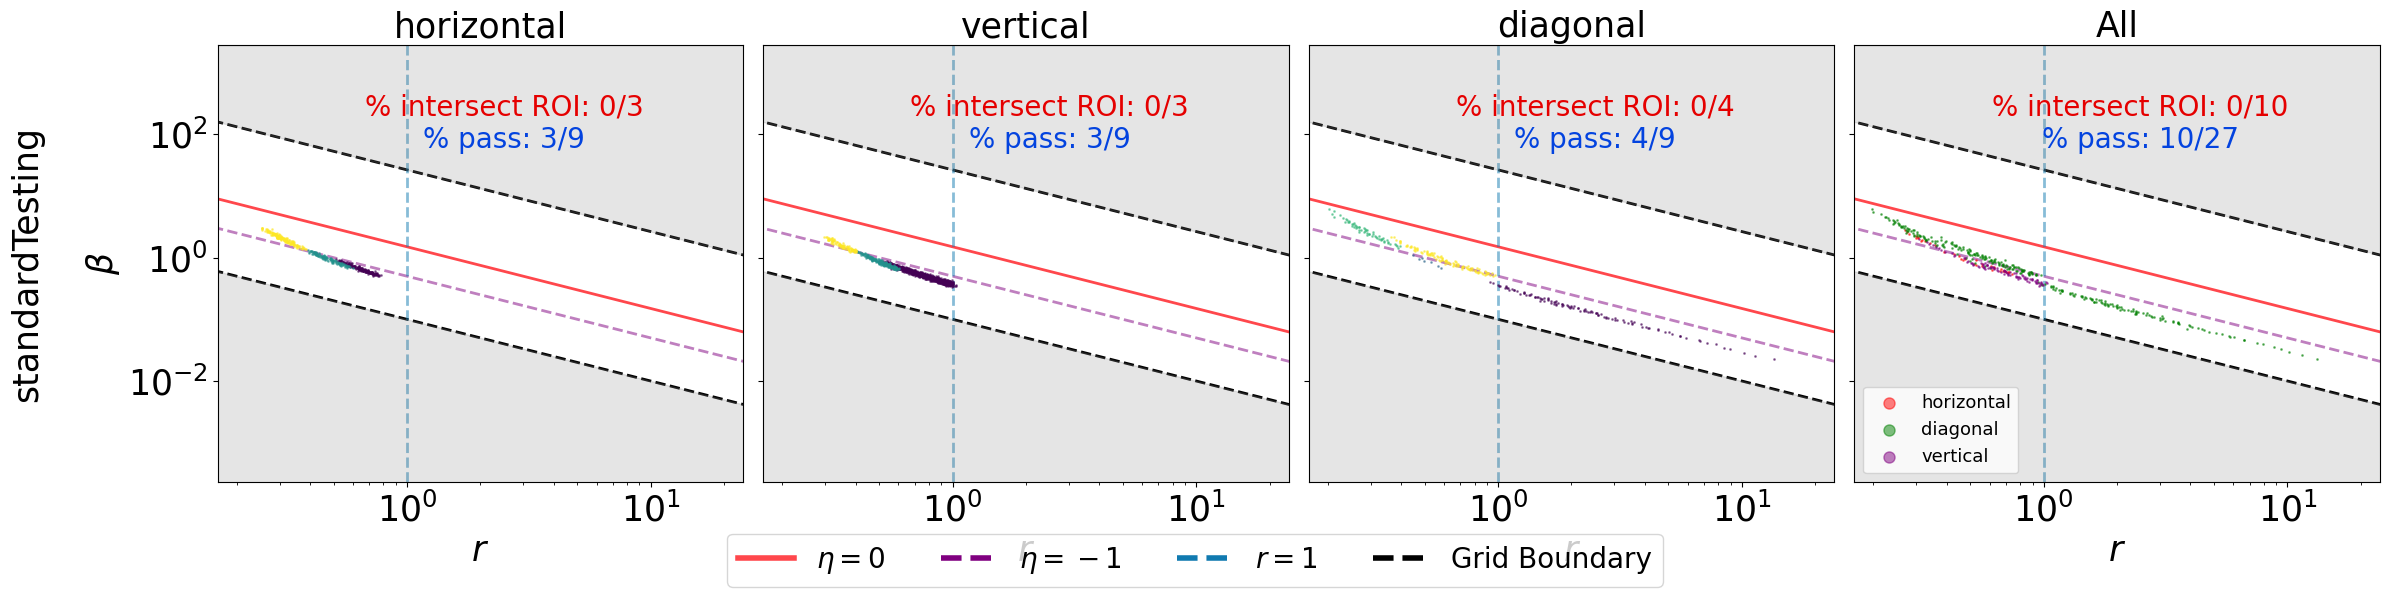

In [145]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("standardTesting", "full")]
directions = ["horizontal", "vertical", "diagonal"]


fontsize=25

# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf
for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        ax = axes[j]
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])
        df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned") & (main_df_all["orientation"] == direction)].copy()
        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin
            
        color_map = plt.get_cmap('viridis')
        num_groups = len(group_list)
        group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}

        x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
        y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
        
        xx, yy = np.meshgrid(x_vals, y_vals)
        points_grid = np.c_[xx.ravel(), yy.ravel()]
        for k, hull in enumerate(hull_list):
            hull_mask = in_hull_list(points_grid, hull)
            points = points_grid[hull_mask]
            points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
            ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        temp_df = df[df["orientation"] == direction]
        #ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")
        
        pass_percent = f"{len(temp_df)}/{len(df_all)}"
        intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"
        ax.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
            textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
        ax.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
            textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))

    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[3]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned")].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned")].copy()
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()

    orientation_colors = {"horizVert": "blue", "diagonal": "green", "fourier": "orange", "vertical": "purple", "horizontal": "red"}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    
    temp_df = df
    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

    ax4.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
            textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    ax4.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    #ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend(markerscale=8, fontsize=fontsize-12)

for i in range(axes.shape[0]):
        ax = axes[i]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)

col_labels = directions + ["All"]
for ax, col in zip(axes, col_labels):
    ax.set_title(col, fontsize=fontsize)

for ax, dataset in zip(axes, datasets):
    ax.annotate(dataset[0], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 25, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=fontsize, rotation=90)
                
for i in range(len(axes)):
        ax = axes[i]
        if i == 0:
            ax.set_ylabel(r"$\beta$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(r"$r$", fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$"),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$'),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize - 5, bbox_to_anchor=(0.5, -0.01), ncol=len(legend_elements))
plt.tight_layout(rect=[0, 0.02, 1, 1])

plt.show()

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_natural_standard.png"), bbox_inches='tight', dpi=1000)


# Learned

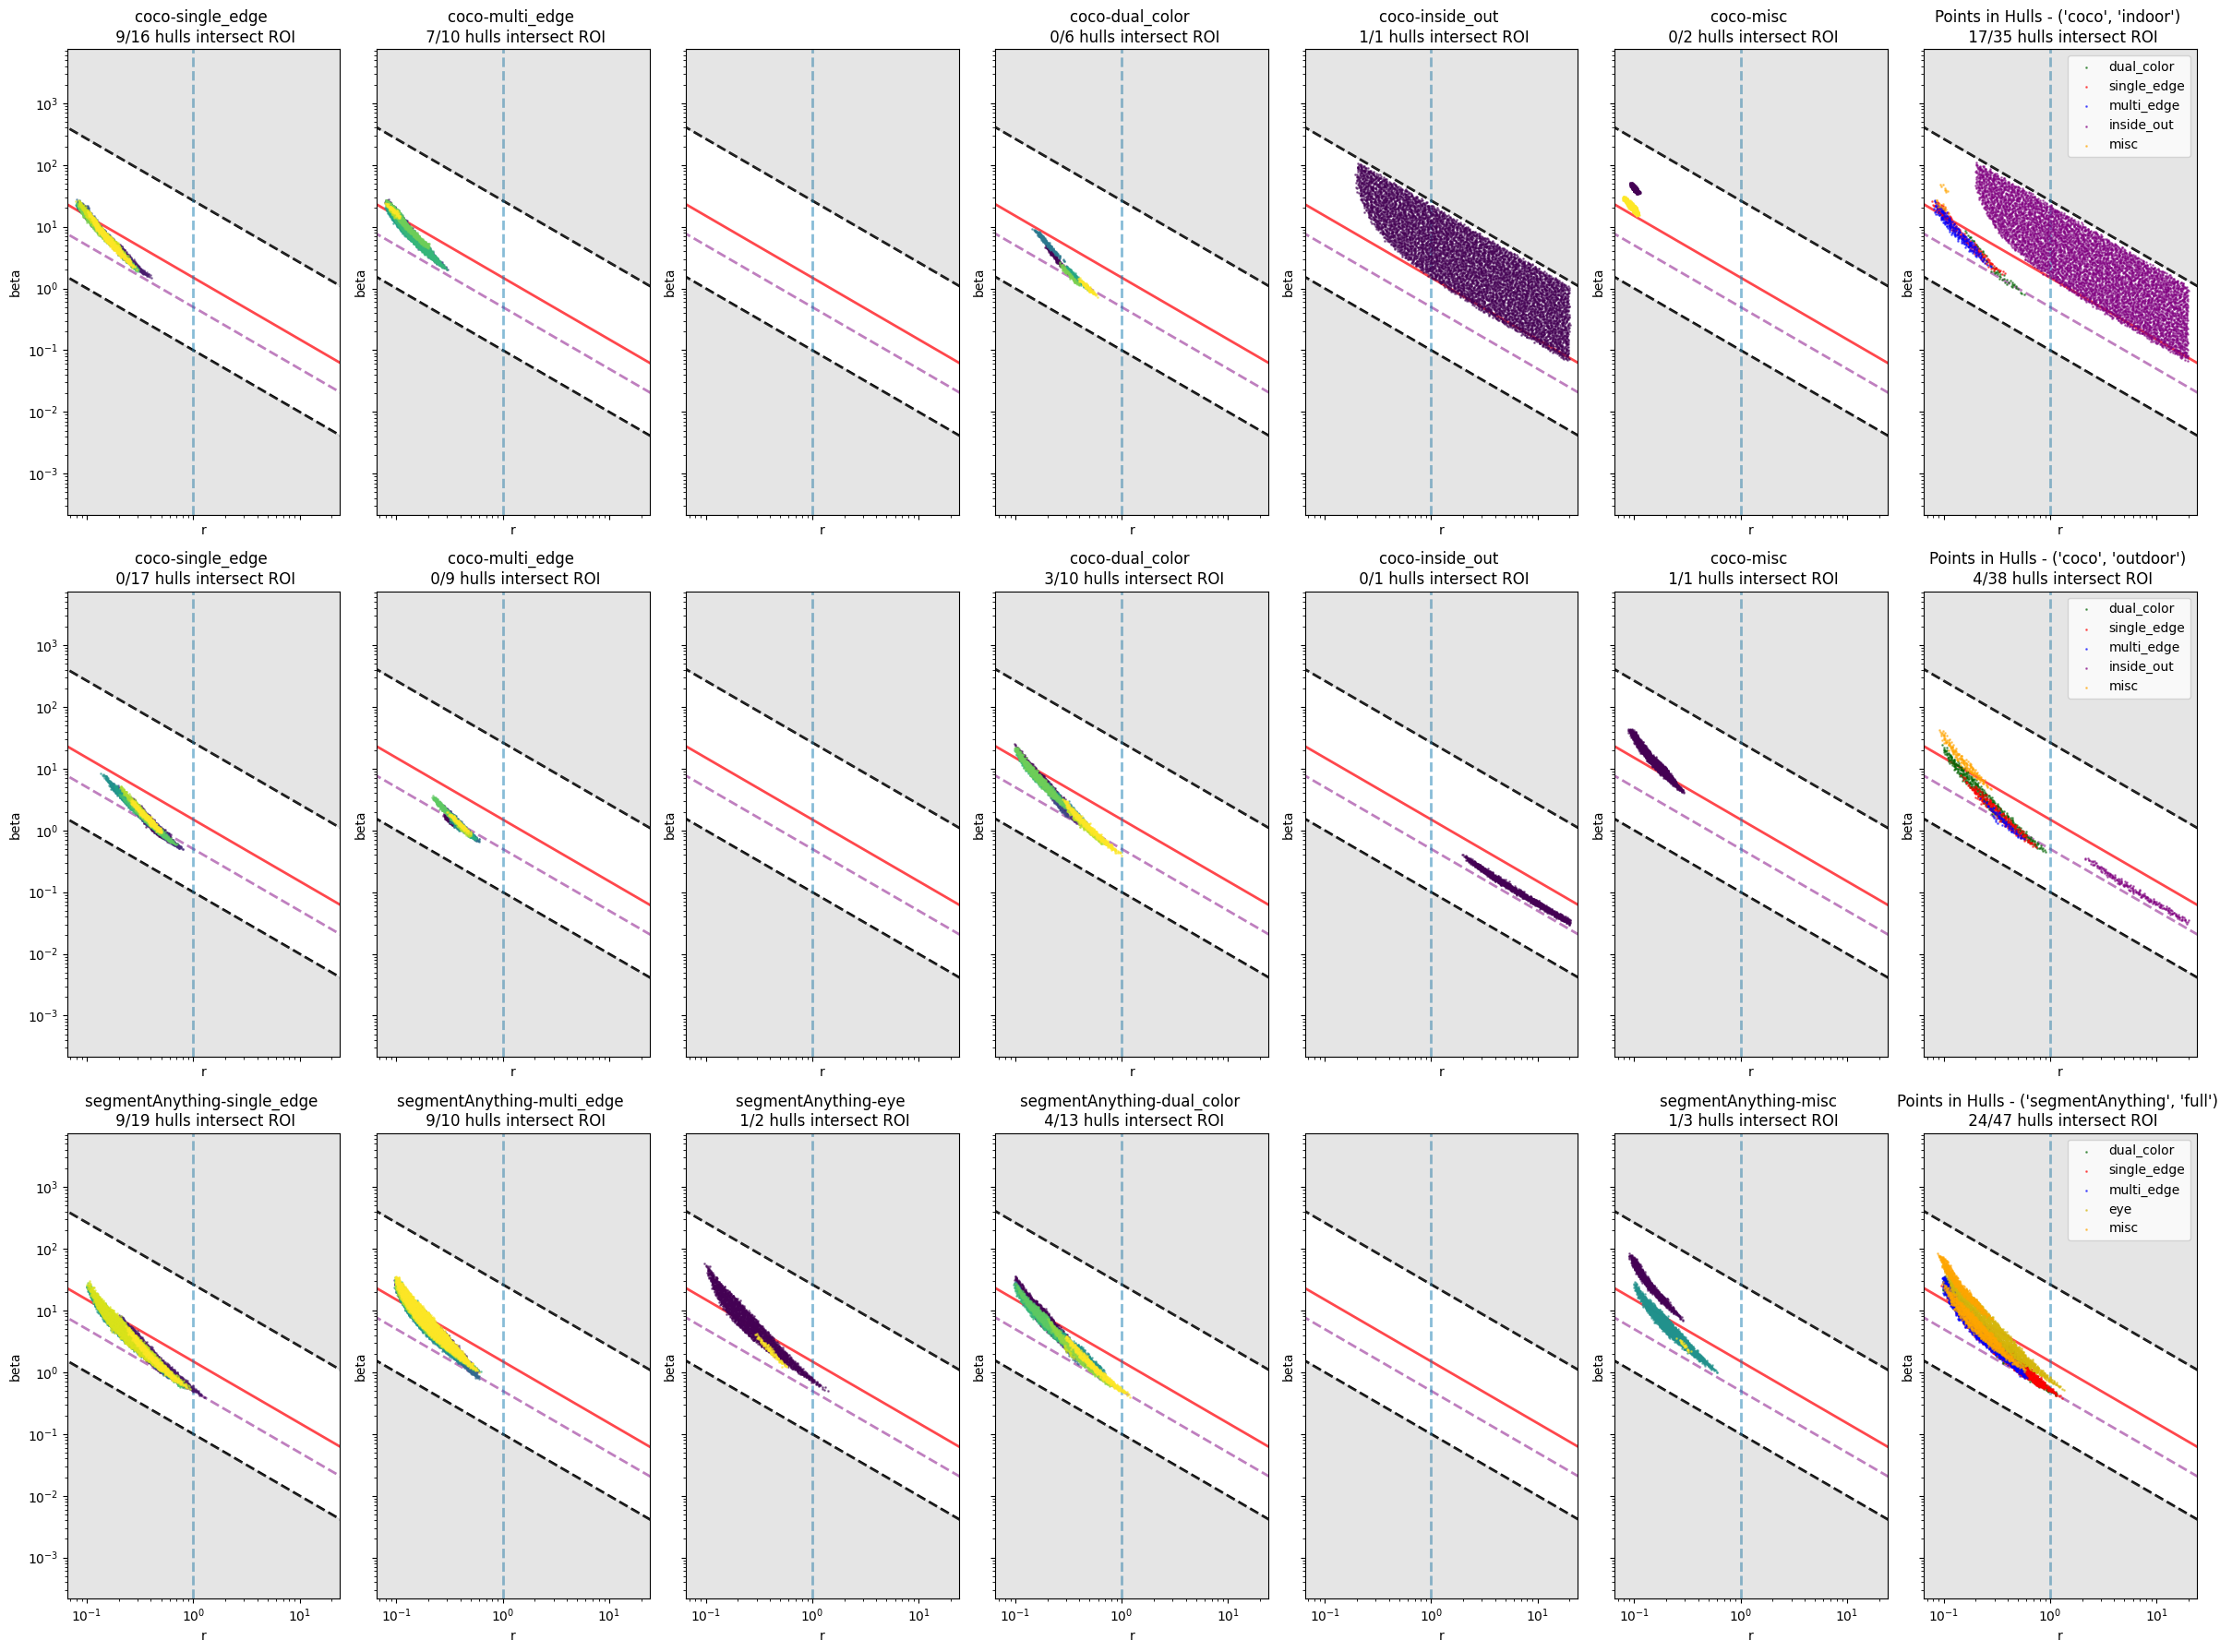

In [146]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("coco", "indoor"), ("coco", "outdoor"), ("segmentAnything", "full")]
directions = ['single_edge', 'multi_edge', 'eye', 'dual_color', 'inside_out', 'misc']


# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(3, 7, figsize=(24, 18), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf
for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        
        ax = axes[i, j]
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned") & (main_df["orientation"] == direction)].copy()
        df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] == "learned") & (main_df_all["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])

        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin
            
        color_map = plt.get_cmap('viridis')
        num_groups = len(group_list)
        group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}
        x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
        y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
        
        xx, yy = np.meshgrid(x_vals, y_vals)
        points_grid = np.c_[xx.ravel(), yy.ravel()]
        for k, hull in enumerate(hull_list):
            hull_mask = in_hull_list(points_grid, hull)
            points = points_grid[hull_mask]
            points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
            ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        temp_df = df[df["orientation"] == direction]
        ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")

    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[i, 6]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned")].copy()
    df = df.dropna(subset=["hull"])

    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    orientation_colors = {'single_edge': 'red',
                'multi_edge': 'blue',
                'eye': 'xkcd:dark yellow',
                'dual_color': 'darkgreen',
                'inside_out': 'purple',
                'misc': 'orange'}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    ax4.set_xlabel("r")
    ax4.set_ylabel("beta")
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend()

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)
       
plt.tight_layout()
plt.show()


if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_natural_learned.png"), bbox_inches='tight', dpi=1000)

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_28997/979444642.py:134: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ylim)


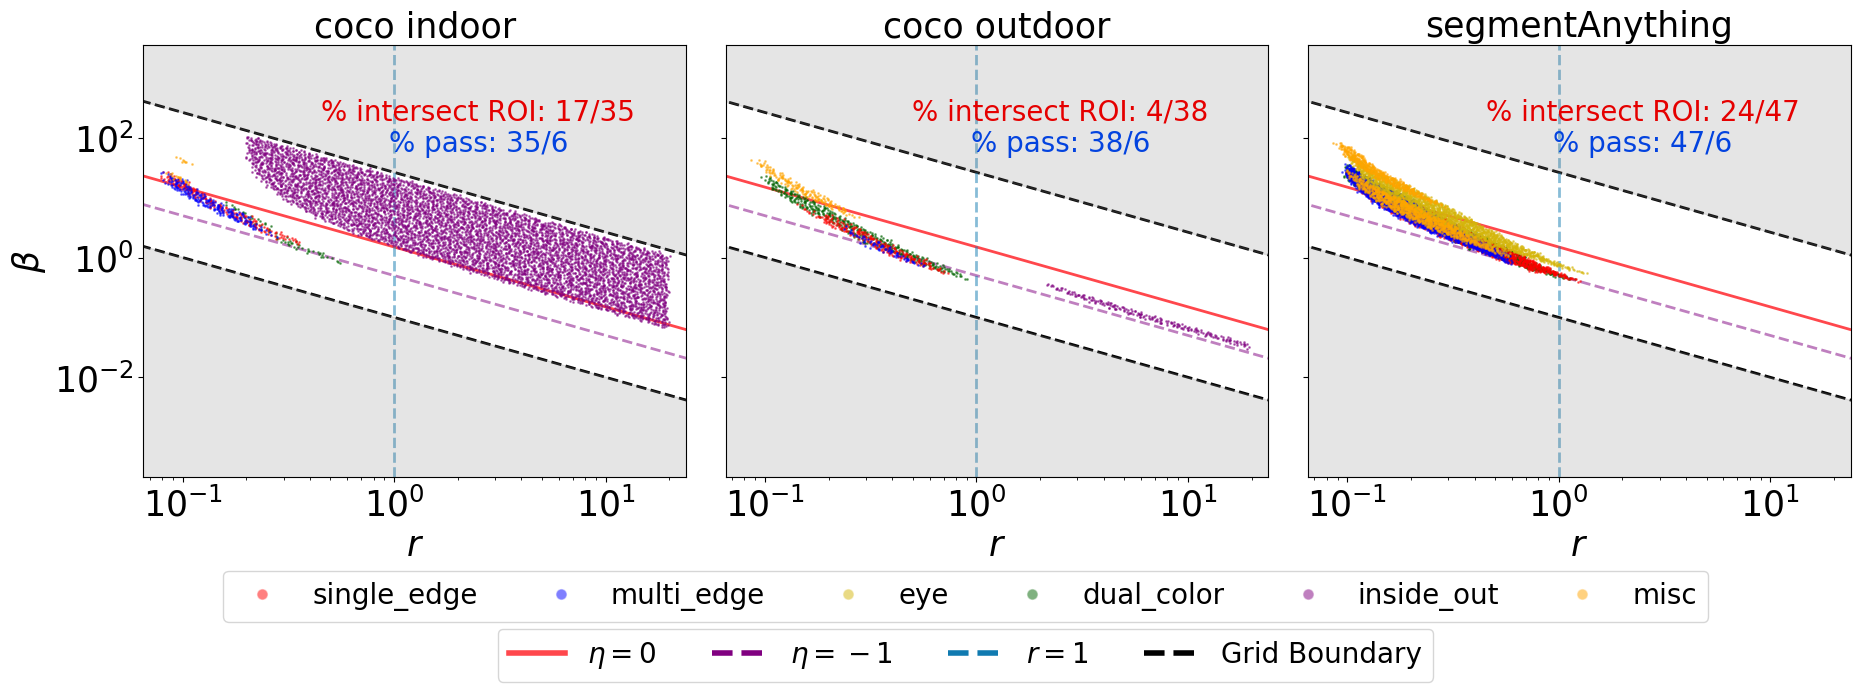

In [147]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("coco", "indoor"), ("coco", "outdoor"), ("segmentAnything", "full")]
directions = ['single_edge', 'multi_edge', 'eye', 'dual_color', 'inside_out', 'misc']
fontsize = 25

# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf

for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])

        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin

for i, DATASET in enumerate(datasets):
    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[i]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned")].copy()
    df = df.dropna(subset=["hull"])
    main_df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] == "learned")].copy()

    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    orientation_colors = {'single_edge': 'red',
                'multi_edge': 'blue',
                'eye': 'xkcd:dark yellow',
                'dual_color': 'darkgreen',
                'inside_out': 'purple',
                'misc': 'orange'}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])

    temp_df = df
    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

    ax4.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
            textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    ax4.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    #ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    #ax4.legend(fontsize=fontsize-10)
    
    #ax4.legend()
    

    # Create one global legend
    
for i in range(axes.shape[0]):
        ax = axes[i]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)
handles, labels = [], []
for orientation, color in orientation_colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=orientation,
                                markerfacecolor=color, markersize=8, alpha=0.5, linestyle='None'))

fig.legend(handles=handles, labels=[h.get_label() for h in handles], loc='lower center', ncol=len(orientation_colors), fontsize=fontsize - 5, bbox_to_anchor=(0.5, -0.01))
plt.tight_layout(rect=[0, 0.15, 1, 1])

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$"),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$'),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize - 5, bbox_to_anchor=(0.5, -0.11), ncol=len(legend_elements))

for i in range(len(axes)):
        ax = axes[i]
        if i == 0:
            ax.set_ylabel(r"$\beta$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(r"$r$", fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)


for ax, dataset in zip(axes, datasets):
    if dataset[0] == "coco":
        ax.set_title(f"{dataset[0]} {dataset[1]}", fontsize=fontsize)
    else:
        ax.set_title(dataset[0], fontsize=fontsize)
plt.show()


if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "combined_region_pointalism_natural_learned.png"), bbox_inches='tight', dpi=1000)

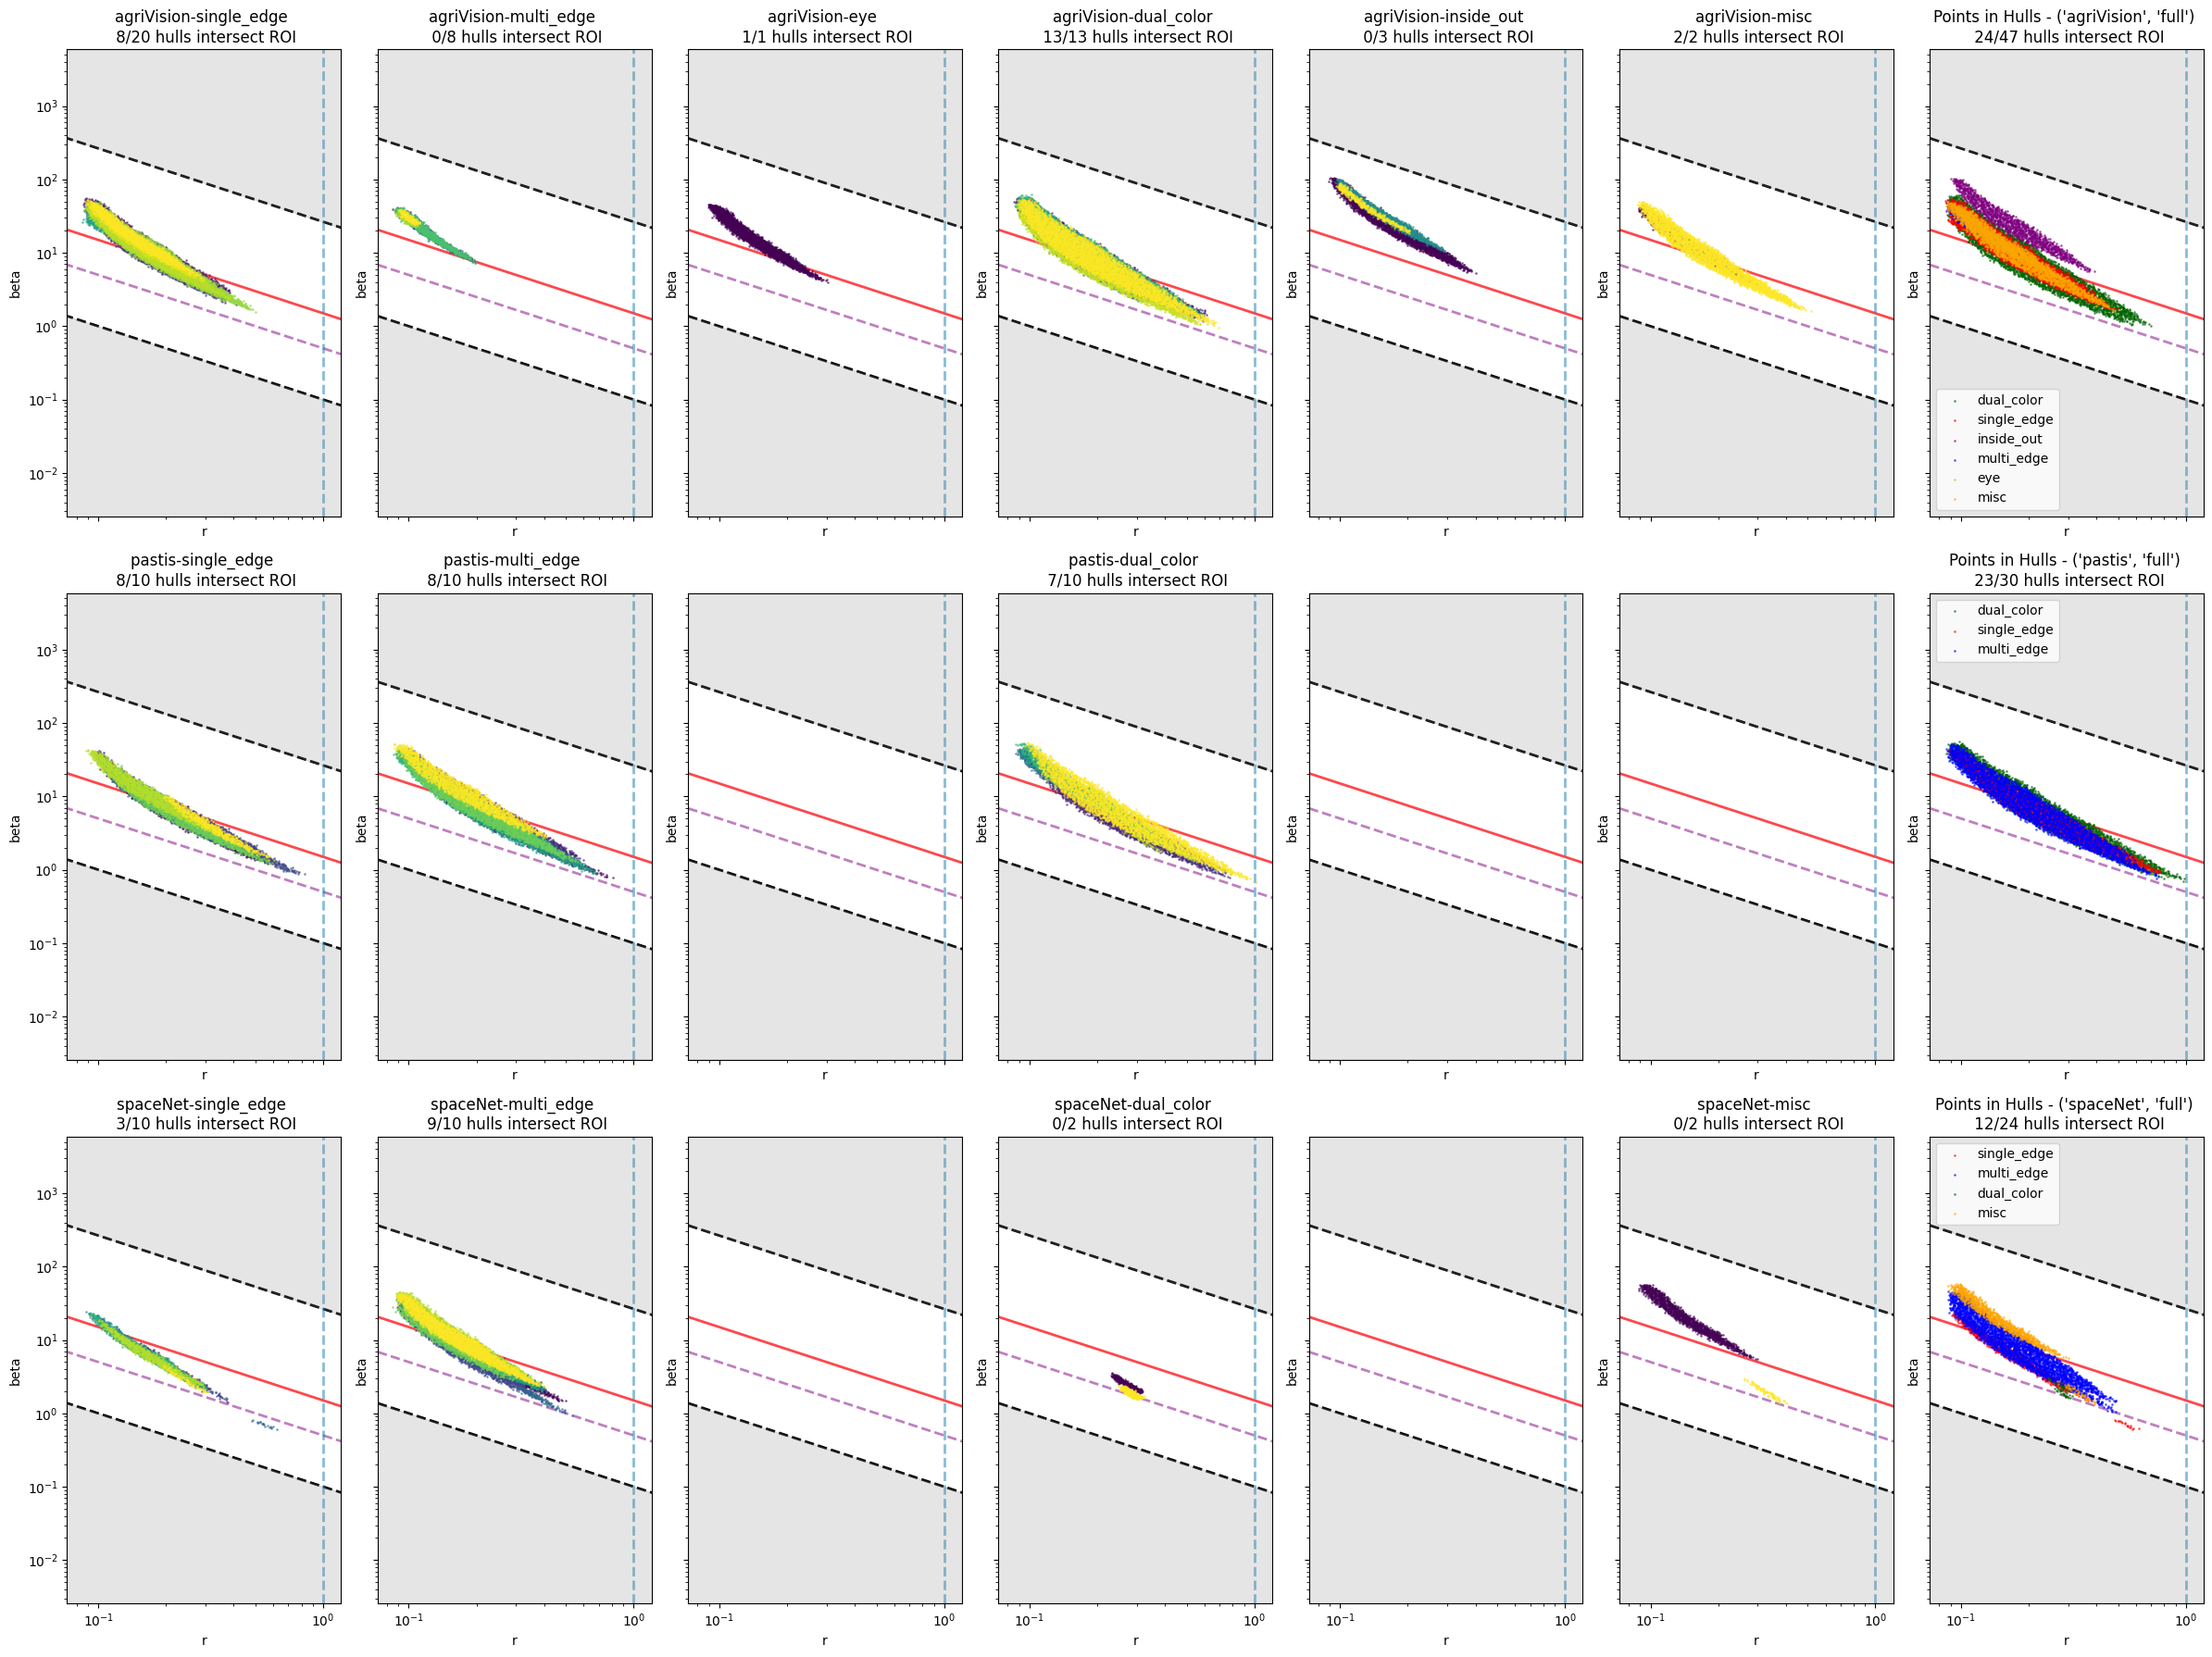

In [148]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("agriVision", "full"), ("pastis", "full"), ("spaceNet", "full")]
directions = ['single_edge', 'multi_edge', 'eye', 'dual_color', 'inside_out', 'misc']


# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(3, 7, figsize=(24, 18), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf
for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        
        ax = axes[i, j]
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])

        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin
            
        color_map = plt.get_cmap('viridis')
        num_groups = len(group_list)
        group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}
        x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
        y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
        
        xx, yy = np.meshgrid(x_vals, y_vals)
        points_grid = np.c_[xx.ravel(), yy.ravel()]
        for k, hull in enumerate(hull_list):
            hull_mask = in_hull_list(points_grid, hull)
            points = points_grid[hull_mask]
            points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
            ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        temp_df = df[df["orientation"] == direction]
        ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")

    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[i, 6]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned")].copy()
    df = df.dropna(subset=["hull"])

    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    orientation_colors = {'single_edge': 'red',
                'multi_edge': 'blue',
                'eye': 'xkcd:dark yellow',
                'dual_color': 'darkgreen',
                'inside_out': 'purple',
                'misc': 'orange'}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    ax4.set_xlabel("r")
    ax4.set_ylabel("beta")
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend()

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)
       
plt.tight_layout()
plt.show()


/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_28997/2475857864.py:134: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ylim)


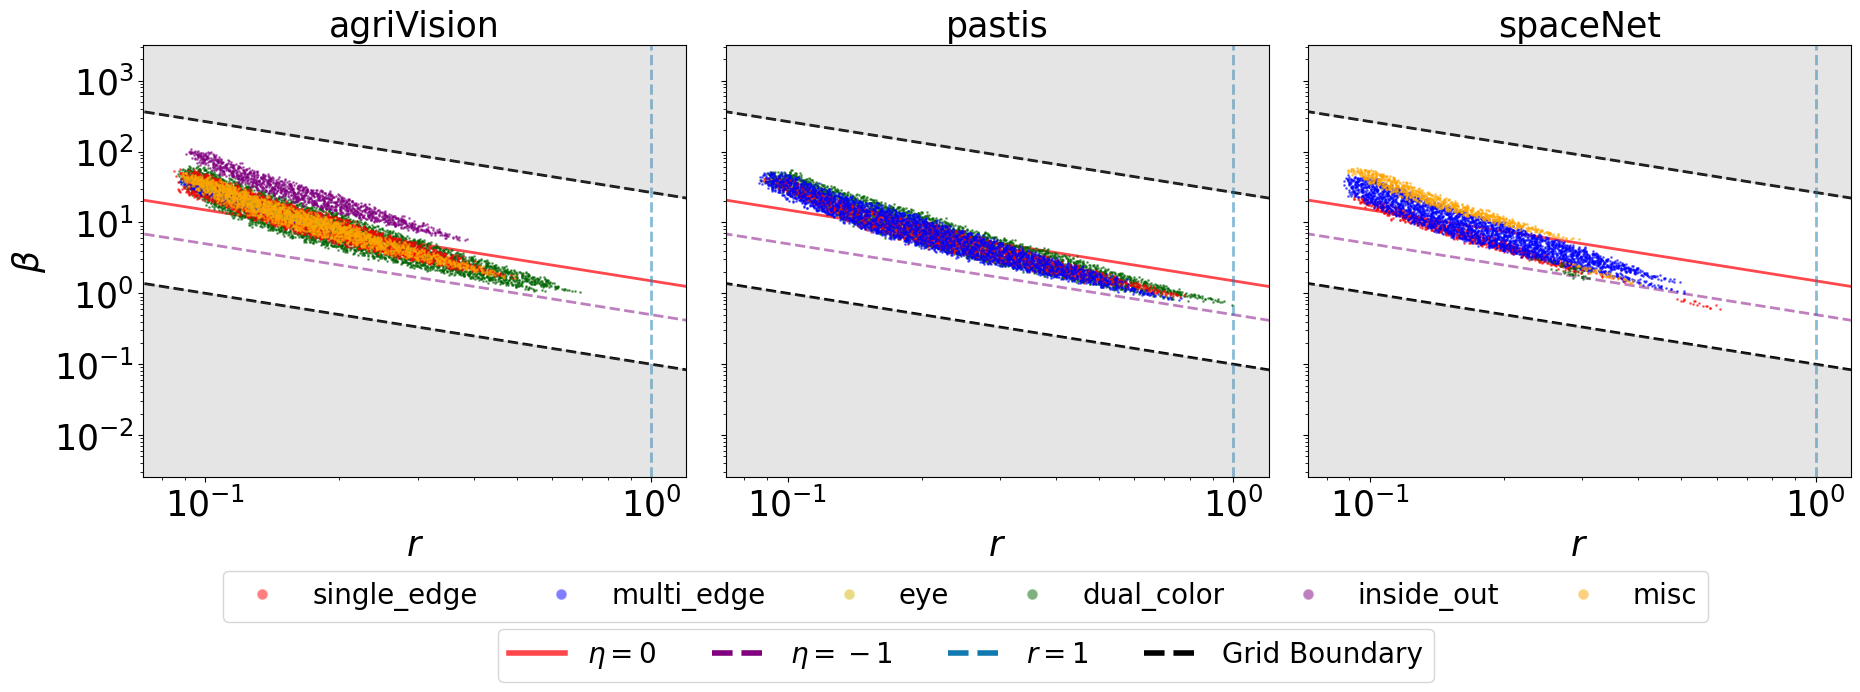

In [149]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("agriVision", "full"), ("pastis", "full"), ("spaceNet", "full")]
directions = ['single_edge', 'multi_edge', 'eye', 'dual_color', 'inside_out', 'misc']
fontsize = 25

# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf

for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])

        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin

for i, DATASET in enumerate(datasets):
    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[i]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned")].copy()
    df = df.dropna(subset=["hull"])
    main_df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] == "learned")].copy()

    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    orientation_colors = {'single_edge': 'red',
                'multi_edge': 'blue',
                'eye': 'xkcd:dark yellow',
                'dual_color': 'darkgreen',
                'inside_out': 'purple',
                'misc': 'orange'}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])

    temp_df = df
    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

    ax4.annotate(f"% intersect ROI: {intersect_percent}", xy=(2.5, 200), 
            textcoords='data', color='xkcd:red', fontsize=fontsize-5, ha='center', 
            bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    ax4.annotate(f"% pass: {pass_percent}", xy=(2.5, 60), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize-5, ha='center', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5))
    #ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    #ax4.legend(fontsize=fontsize-10)
    
    #ax4.legend()
    

    # Create one global legend
    
for i in range(axes.shape[0]):
        ax = axes[i]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)
handles, labels = [], []
for orientation, color in orientation_colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=orientation,
                                markerfacecolor=color, markersize=8, alpha=0.5, linestyle='None'))

fig.legend(handles=handles, labels=[h.get_label() for h in handles], loc='lower center', ncol=len(orientation_colors), fontsize=fontsize - 5, bbox_to_anchor=(0.5, -0.01))


lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$"),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$'),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize - 5, bbox_to_anchor=(0.5, -0.11), ncol=len(legend_elements))

plt.tight_layout(rect=[0, 0.15, 1, 1])
for i in range(len(axes)):
        ax = axes[i]
        if i == 0:
            ax.set_ylabel(r"$\beta$", fontsize=fontsize)
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(r"$r$", fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)


for ax, dataset in zip(axes, datasets):
    if dataset[0] == "coco":
        ax.set_title(f"{dataset[0]} {dataset[1]}", fontsize=fontsize)
    else:
        ax.set_title(dataset[0], fontsize=fontsize)
plt.show()


if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "combined_region_pointalism_remote_learned.png"), bbox_inches='tight', dpi=1000)

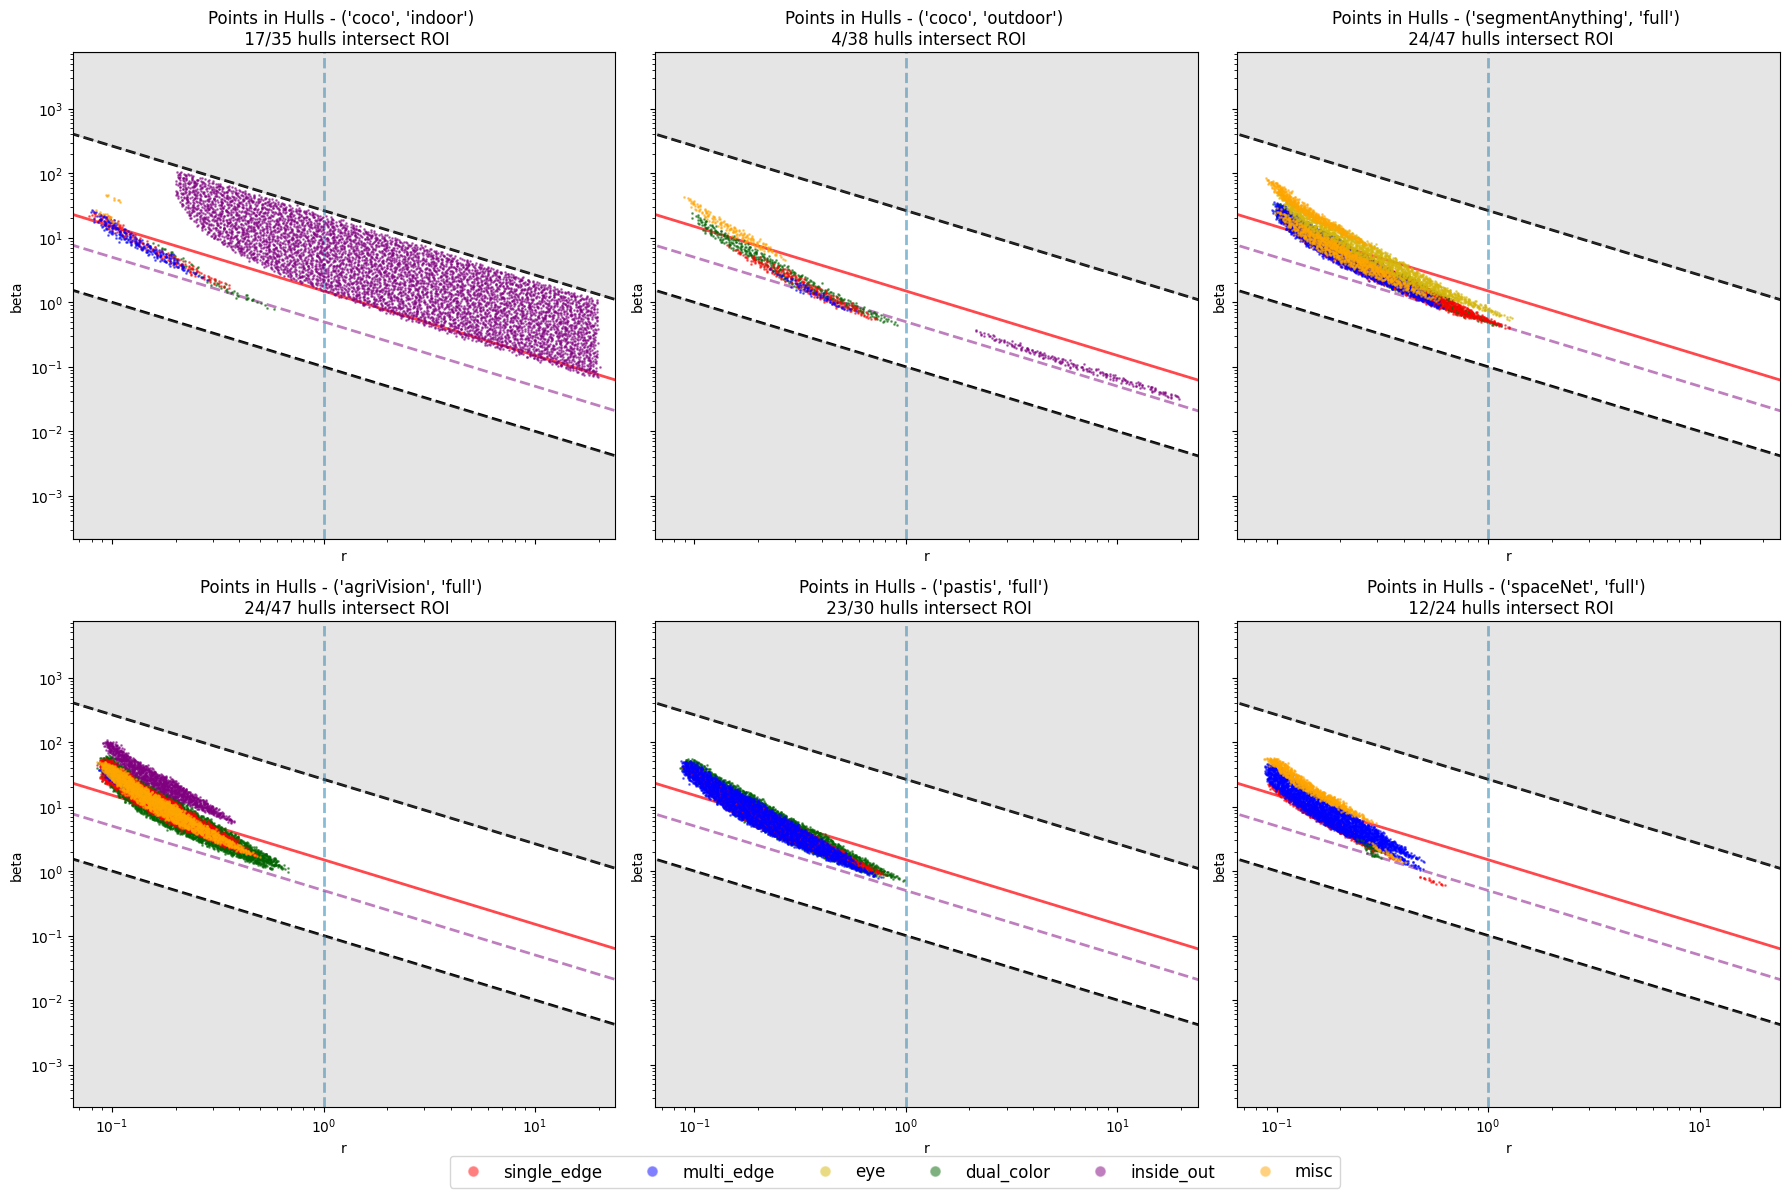

In [150]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("coco", "indoor"), ("coco", "outdoor"), ("segmentAnything", "full"), ("agriVision", "full"), ("pastis", "full"), ("spaceNet", "full")]
directions = ['single_edge', 'multi_edge', 'eye', 'dual_color', 'inside_out', 'misc']


# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf

for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])

        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin

for i, DATASET in enumerate(datasets):
    # Fourth column: plot by orientation for each DATASET
    if i < 3:
        ax4 = axes[0, i]
    else:
        ax4 = axes[1, i - 3]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned")].copy()
    df = df.dropna(subset=["hull"])

    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    orientation_colors = {'single_edge': 'red',
                'multi_edge': 'blue',
                'eye': 'xkcd:dark yellow',
                'dual_color': 'darkgreen',
                'inside_out': 'purple',
                'misc': 'orange'}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    ax4.set_xlabel("r")
    ax4.set_ylabel("beta")
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    #ax4.legend()

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)
       
handles, labels = [], []
for orientation, color in orientation_colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=orientation,
                                markerfacecolor=color, markersize=8, alpha=0.5, linestyle='None'))

fig.legend(handles=handles, labels=[h.get_label() for h in handles], loc='lower center', ncol=len(orientation_colors), fontsize='large')
plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()




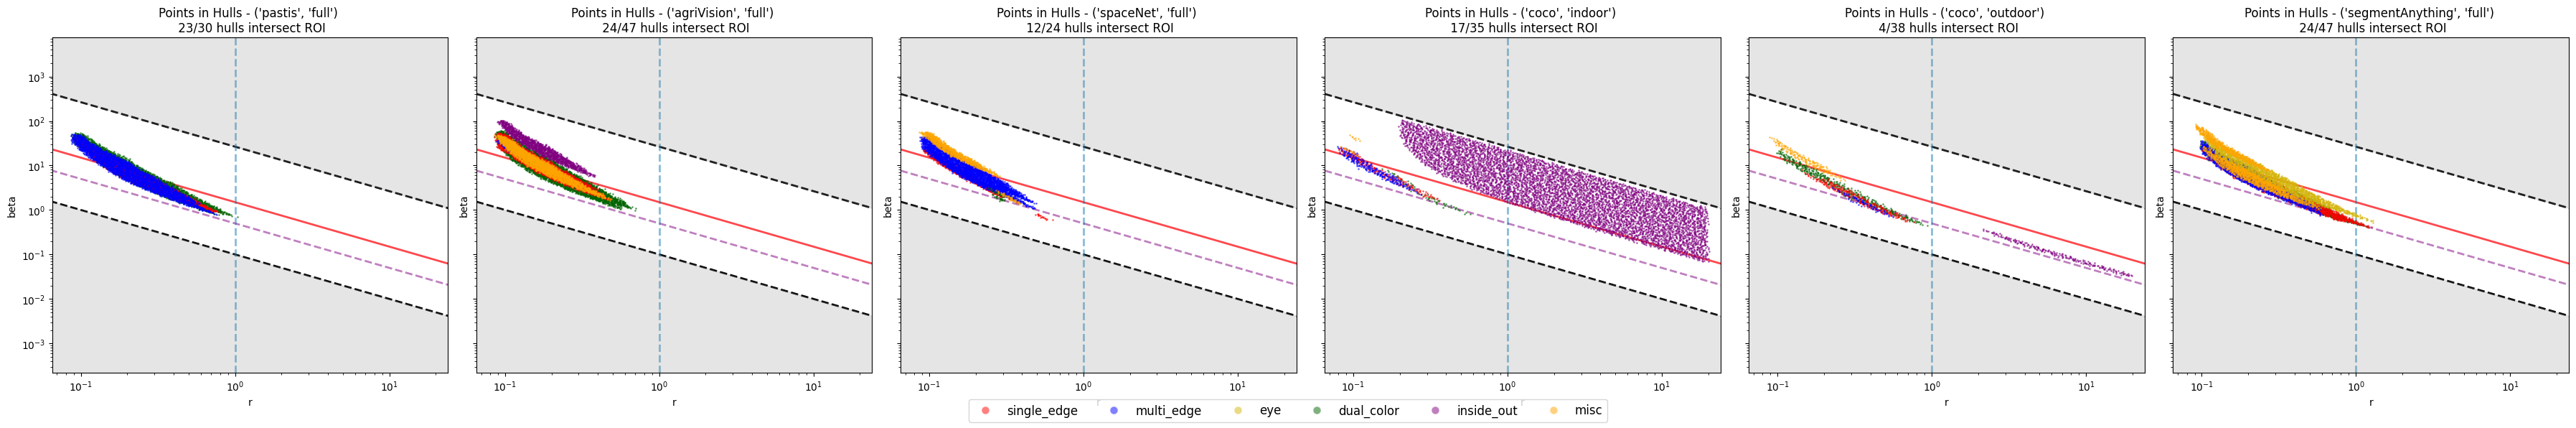

In [151]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("pastis", "full"), ("agriVision", "full"), ("spaceNet", "full"), ("coco", "indoor"), ("coco", "outdoor"), ("segmentAnything", "full")]
directions = ['single_edge', 'multi_edge', 'eye', 'dual_color', 'inside_out', 'misc']


# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(1, 6, figsize=(36, 6), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf

for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])

        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin

for i, DATASET in enumerate(datasets):
    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[i]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned")].copy()
    df = df.dropna(subset=["hull"])

    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    orientation_colors = {'single_edge': 'red',
                'multi_edge': 'blue',
                'eye': 'xkcd:dark yellow',
                'dual_color': 'darkgreen',
                'inside_out': 'purple',
                'misc': 'orange'}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    ax4.set_xlabel("r")
    ax4.set_ylabel("beta")
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    #ax4.legend()

for i in range(axes.shape[0]):
        ax = axes[i]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)
       
handles, labels = [], []
for orientation, color in orientation_colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=orientation,
                                markerfacecolor=color, markersize=8, alpha=0.5, linestyle='None'))

fig.legend(handles=handles, labels=[h.get_label() for h in handles], loc='lower center', ncol=len(orientation_colors), fontsize='large')
plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()


if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "combined_region_pointalism_all_learned_line.png"), bbox_inches='tight', dpi=1000)

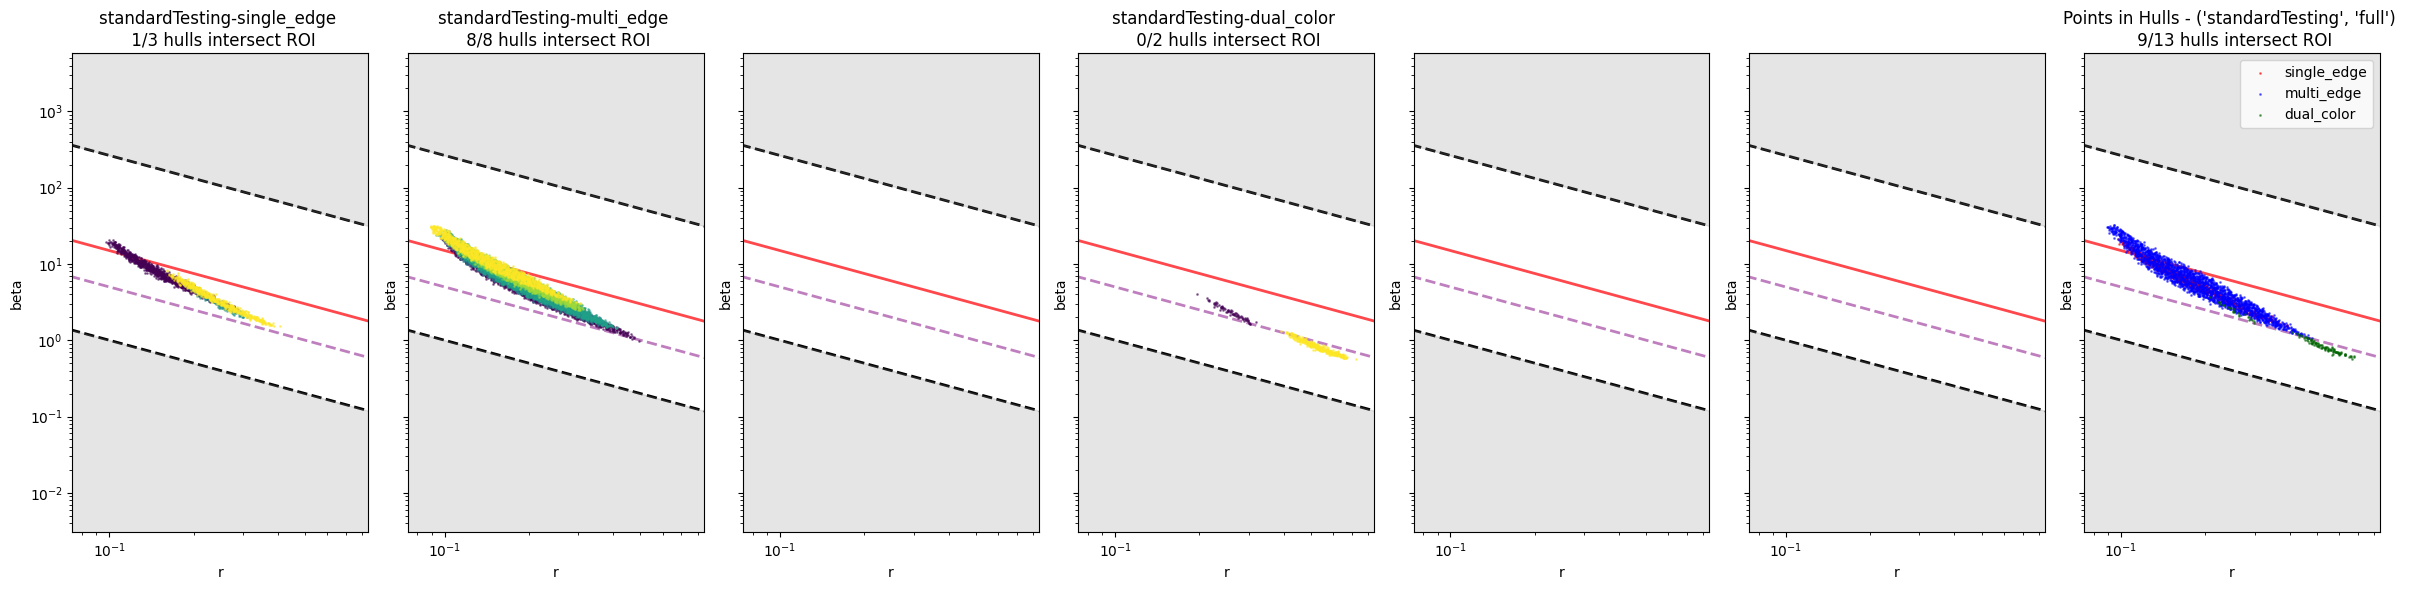

In [152]:
num_points = 150
JITTER_FACTOR = 50
size = 1
datasets = [("standardTesting", "full")]
directions = ['single_edge', 'multi_edge', 'eye', 'dual_color', 'inside_out', 'misc']


# Add a fourth column to the right for the new plots
fig, axes = plt.subplots(1, 7, figsize=(24, 6), sharex=True, sharey=True)
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf
for i, DATASET in enumerate(datasets):
    for j, direction in enumerate(directions):
        
        ax = axes[j]
        df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned") & (main_df["orientation"] == direction)].copy()
        df = df.dropna(subset=["hull"])

        group_list = df["group"].unique()
        hull_list = []
        all_hulls = []
        for group in group_list:
            hull_list.append(df[df["group"] == group]["hull"])
            all_hulls.extend(df[df["group"] == group]["hull"])
        if len(all_hulls) == 0:
            continue
        all_points = np.vstack([hull.points for hull in all_hulls])
        xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
        ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


        if xmax > global_xmax:
            global_xmax = xmax
        if ymax > global_ymax:
            global_ymax = ymax
        if xmin < global_xmin:
            global_xmin = xmin
        if ymin < global_ymin:
            global_ymin = ymin
            
        color_map = plt.get_cmap('viridis')
        num_groups = len(group_list)
        group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}
        x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
        y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
        
        xx, yy = np.meshgrid(x_vals, y_vals)
        points_grid = np.c_[xx.ravel(), yy.ravel()]
        for k, hull in enumerate(hull_list):
            hull_mask = in_hull_list(points_grid, hull)
            points = points_grid[hull_mask]
            points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
            ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        temp_df = df[df["orientation"] == direction]
        ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")

    # Fourth column: plot by orientation for each DATASET
    ax4 = axes[6]
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] == "learned")].copy()
    df = df.dropna(subset=["hull"])

    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        continue
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    orientation_colors = {'single_edge': 'red',
                'multi_edge': 'blue',
                'eye': 'xkcd:dark yellow',
                'dual_color': 'darkgreen',
                'inside_out': 'purple',
                'misc': 'orange'}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    ax4.set_xlabel("r")
    ax4.set_ylabel("beta")
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend()

for i in range(axes.shape[0]):
        ax = axes[i]
        x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
        eta_vals_global = 0 * np.zeros_like(x_vals_global)
        eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
        eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
        eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
        eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
        eta_neg_1 = -1 + np.zeros_like(x_vals_global)
        
        roi_global = (eta_vals_global + 1.5) / x_vals_global
        roi_lower = (eta_roi_lower + 1.5) / x_vals_global
        roi_upper = (eta_roi_upper + 1.5) / x_vals_global
        beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
        beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
        beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global
        
        ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
       #ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
        ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
        ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.5)
        ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.5)

        

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
        ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)

        ax.set_xlabel("r")
        ax.set_ylabel("beta")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
        ax.set_ylim(ylim)
        #ax.set_ylim(global_ymin, global_ymax)
       
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_remote_standard.png"), bbox_inches='tight', dpi=1000)